<a href="https://colab.research.google.com/github/MatteoBettini/Stock-Market-Prediction-2020/blob/main/notebooks/FInal%20assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Take-home Assignment

# Imports

In [694]:
# To plot figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

import sklearn
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

import os
import datetime
import pandas as pd
import numpy as np

# Load the TensorBoard notebook extension
%load_ext tensorboard

# To make this notebook's output stable across runs
random_state = 42
np.random.seed(random_state)
tf.random.set_seed(random_state)

plt.rcParams['figure.figsize'] = (15.0, 10.0)
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['figure.subplot.bottom'] = 0.125
plt.rcParams['figure.edgecolor'] = 'white'
plt.rcParams["savefig.dpi"] = 300

plt.rcParams['font.size'] = 15
plt.rcParams['axes.labelsize'] = 15
plt.rcParams['xtick.labelsize'] = 15
plt.rcParams['ytick.labelsize'] = 15

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [695]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))



Found GPU at: /device:GPU:0


In [696]:
"""
from google.colab import drive
drive.mount('/content/drive')

ax = nasdaq_df.plot(y=["Close"])

fig = ax.get_figure()
fig.savefig('/content/drive/My Drive/Stock_market_figures/close.png')
"""

'\nfrom google.colab import drive\ndrive.mount(\'/content/drive\')\n\nax = nasdaq_df.plot(y=["Close"])\n\nfig = ax.get_figure()\nfig.savefig(\'/content/drive/My Drive/Stock_market_figures/close.png\')\n'

# Dataset exploration

In this section we will upload and explore the dataset "**Processed_NASDAQ**",  containing several daily features of NASDAQ Composite from 2010 to 2017. The dataset was acquired from [this repository](https://archive.ics.uci.edu/ml/datasets/CNNpred%3A+CNN-based+stock+market+prediction+using+a+diverse+set+of+variables#).

It covers features from various categories of technical indicators, future contracts, price of commodities, important indices of markets around the world, price of major companies in the U.S. market, and treasury bill rates. Sources and thorough description of features have been mentioned in the paper "[CNNpred: CNN-based stock market prediction using a diverse set of variables](https://arxiv.org/pdf/1810.08923.pdf)".

## 1 - Loading the dataset

In [697]:
nasdaq_url = 'https://raw.githubusercontent.com/MatteoBettini/Stock-Market-Prediction-2020/main/stock_markets_datasets/Processed_NASDAQ.csv?token=ANHXQQOLNU7CE7V2OTZJ43C76A552'
dji_url = 'https://raw.githubusercontent.com/MatteoBettini/Stock-Market-Prediction-2020/main/stock_markets_datasets/Processed_DJI.csv?token=ANHXQQOXYQZSSSTVFKX6RZS74XDXA'
nyse_url = 'https://raw.githubusercontent.com/MatteoBettini/Stock-Market-Prediction-2020/main/stock_markets_datasets/Processed_NYSE.csv?token=ANHXQQNAISMPCLVLRTGNJBC74XD2C'
russel_url = 'https://raw.githubusercontent.com/MatteoBettini/Stock-Market-Prediction-2020/main/stock_markets_datasets/Processed_RUSSELL.csv?token=ANHXQQPGLBLSM3B36OLWIPC74XD3U'
s_p_url = 'https://raw.githubusercontent.com/MatteoBettini/Stock-Market-Prediction-2020/main/stock_markets_datasets/Processed_S%26P.csv?token=ANHXQQNRFS3NKP2XCF5Q5MS74XD5K'

In [698]:
nasdaq_df = pd.read_csv(nasdaq_url, parse_dates=["Date"], index_col="Date")
# Dataset is now stored in a Pandas Dataframe

We load the .csv file telling pandas to parse the date column and to use it to index the data.

## 2 - Exploring the dataset

Now that we have loaded the dataset we can start inspecting the data.

In [699]:
nasdaq_df.head(10)

,Close,Volume,mom,mom1,mom2,mom3,ROC_5,ROC_10,ROC_15,ROC_20,EMA_10,EMA_20,EMA_50,EMA_200,DTB4WK,DTB3,DTB6,DGS5,DGS10,Oil,Gold,DAAA,DBAA,GBP,JPY,CAD,CNY,AAPL,AMZN,GE,JNJ,JPM,MSFT,WFC,XOM,FCHI,FTSE,GDAXI,GSPC,HSI,...,NYSE,TE1,TE2,TE3,TE5,TE6,DE1,DE2,DE4,DE5,DE6,CTB3M,CTB6M,CTB1Y,Name,AUD,Brent,CAC-F,copper-F,WIT-oil,DAX-F,DJI-F,EUR,FTSE-F,gold-F,HSI-F,KOSPI-F,NASDAQ-F,GAS-F,Nikkei-F,NZD,silver-F,RUSSELL-F,S&P-F,CHF,Dollar index-F,Dollar index,wheat-F,XAG,XAU
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2009-12-31,2269.149902,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.04,0.06,0.20,2.69,3.85,NaN,NaN,5.33,6.39,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,3.81,3.79,3.65,0.02,0.16,1.06,2.54,6.19,6.33,6.35,NaN,NaN,NaN,NASDAQ,0.35,-0.13,0.15,0.09,0.10,0.48,-1.19,-0.12,0.27,0.34,1.68,-0.07,-0.96,-2.40,0.67,0.03,0.26,-1.08,-1.00,-0.11,-0.08,-0.06,-0.48,0.30,0.39
2010-01-04,2308.419922,0.560308,0.017306,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.05,0.08,0.18,2.65,3.85,0.026830,0.000000,5.35,6.39,-0.004222,-0.004467,-0.010644,-0.001991,0.015565,-0.004609,0.021150,0.004192,0.028318,0.015420,0.012227,0.014078,0.019724,NaN,NaN,0.016043,NaN,...,0.019733,3.80,3.77,3.67,0.03,0.13,1.04,2.54,6.21,6.31,6.34,-0.100000,-0.043860,-0.014870,NASDAQ,1.73,2.81,1.99,1.36,2.71,0.96,1.28,0.61,1.74,2.05,-0.52,0.54,1.51,5.60,0.31,1.52,3.26,1.61,1.62,-0.57,-0.59,-0.42,3.12,3.91,2.10
2010-01-05,2308.709961,0.225994,0.000126,0.017306,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.03,0.07,0.17,2.56,3.77,0.002699,0.001560,5.24,6.30,-0.007628,-0.009838,-0.001441,0.000015,0.001729,0.005900,0.005178,-0.011596,0.019370,0.000323,0.027452,0.003904,-0.000264,0.004036,-0.002718,0.003116,0.020909,...,0.003839,3.74,3.70,3.60,0.04,0.14,1.06,2.53,6.13,6.23,6.27,-0.055556,-0.073394,-0.033962,NASDAQ,-0.08,0.59,-0.11,0.24,0.32,-0.14,-0.04,-0.31,0.38,0.04,2.03,-0.18,-0.08,-4.20,0.47,-0.07,1.96,-0.20,0.31,0.43,0.03,0.12,-0.90,1.42,-0.12
2010-01-06,2301.090088,-0.048364,-0.003300,0.000126,0.017306,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.03,0.06,0.15,2.60,3.85,0.016883,0.006009,5.30,6.34,0.002067,0.008418,-0.007311,0.000191,-0.015906,-0.018116,-0.005151,0.008134,0.005494,-0.006137,0.001425,0.008643,0.001186,0.001358,0.000410,0.000546,0.006153,...,0.003104,3.82,3.79,3.70,0.03,0.12,1.04,2.49,6.19,6.28,6.31,-0.117647,0.000000,0.015625,NASDAQ,0.91,1.61,0.15,2.41,1.72,-0.01,0.01,0.31,0.16,1.59,0.79,0.78,-0.36,6.60,0.19,0.56,2.15,-0.02,0.07,-0.56,-0.24,-0.17,2.62,2.25,1.77
2010-01-07,2300.050049,0.007416,-0.000452,-0.003300,0.000126,0.017306,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.02,0.05,0.16,2.62,3.85,-0.006256,0.000221,5.31,6.33,-0.005609,0.011196,0.002035,-0.000073,-0.001849,-0.017013,0.051780,-0.007137,0.019809,-0.010400,0.036286,-0.003142,0.001775,-0.000597,-0.002481,0.004001,-0.006567,...,0.002200,3.83,3.80,3.69,0.03,0.14,1.02,2.48,6.17,6.28,6.31,0.066667,0.019802,0.007692,NASDAQ,-0.41,-0.46,0.15,-1.90,-0.63,-0.12,0.28,-0.66,0.06,-0.25,-0.60,-1.27,-0.05,-3.38,-0.09,-0.72,0.94,0.50,0.40,0.58,0.58,0.54,-1.85,0.22,-0.58
2010-01-08,2317.169922,-0.054915,0.007443,-0.000452,-0.003300,0.000126,2.116212,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.02,0.05,0.15,2.57,3.83,0.001695,-0.003097,5.32,6.32,0.005656,-0.007817,-0.004062,-0.000044,0.006648,0.027077,0.021538,0.003438,-0.002456,0.006897,-0.009269,-0.004012,0.005054,0.001357,0.003032,0.002882,0.001226,...,0.004249,3.81,3.78,3.68,0.03,0.13,1.00,2.49,6.17,6.27,6.30,-0.062500,-0.067961,-0.019084,NASDAQ,0.88,-0.17,0.53,-0.70,0.11,0.27,0.20,0.66,0.02,0.45,0.06,0.43,0.67,-0.98,1.03,0.61,0.68,0.64,0.35,-0.98,-0.58,-0.56,2.07,1.26,0.38
2010-01-11,2312.409912,-0.031463,-0.002054,0.007443,-0.000452,-0.003300,0.172845,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.01,0.04,0.13,2.58,3.85,-0.002417,0.023297,5.35,6.32,0.005543,-0.006130,0.003884,-0.000147,-0.008822,-0.024041,0.009639,0.000156,-0.003357,-0.012720,-0.002079,0.011220,-0.000507,0.000705,0.000479,0.001747,0.005147,...,0.003192,3.84,3.81,3.72,0.03,0.

Taking a peak at the first ten elements we can already see that there are a lot of missing values. They will be treated accordingly in [this section](#missing_values).


We can also see that the dates inculuded in the dataset are referring only to working days as the stock market is open only on those days.

We can get a confirmation of this by looking at the following rows where we see that 16,17 January 2010 are not present because it was a weekend and 18 January 2010 is not present because of the federal U.S. festivity of "Martin Luther King Jr. Day".

This is not a problem for our machine learning pipeline as we will map the 'Date' feature into a categorical feature representing the day of the week.
More information on this will be provided in [this section](#cathegorical_values).

In [700]:
nasdaq_df.iloc[9:13]

,Close,Volume,mom,mom1,mom2,mom3,ROC_5,ROC_10,ROC_15,ROC_20,EMA_10,EMA_20,EMA_50,EMA_200,DTB4WK,DTB3,DTB6,DGS5,DGS10,Oil,Gold,DAAA,DBAA,GBP,JPY,CAD,CNY,AAPL,AMZN,GE,JNJ,JPM,MSFT,WFC,XOM,FCHI,FTSE,GDAXI,GSPC,HSI,...,NYSE,TE1,TE2,TE3,TE5,TE6,DE1,DE2,DE4,DE5,DE6,CTB3M,CTB6M,CTB1Y,Name,AUD,Brent,CAC-F,copper-F,WIT-oil,DAX-F,DJI-F,EUR,FTSE-F,gold-F,HSI-F,KOSPI-F,NASDAQ-F,GAS-F,Nikkei-F,NZD,silver-F,RUSSELL-F,S&P-F,CHF,Dollar index-F,Dollar index,wheat-F,XAG,XAU
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2010-01-14,2316.739990,-0.027683,0.003830,0.011212,-0.013017,-0.002054,0.725634,NaN,NaN,NaN,2302.394971,NaN,NaN,NaN,0.02,0.05,0.14,2.51,3.76,-0.003892,0.009758,5.17,6.22,0.002941,-0.001816,-0.007179,0.000029,-0.005792,-0.013632,-0.007724,0.002001,0.009943,0.020099,0.014346,0.000144,0.003727,0.004513,0.004316,0.002426,-0.001455,...,0.002474,3.74,3.71,3.62,0.03,0.12,1.05,2.46,6.08,6.17,6.20,-0.066667,-0.030928,-0.015686,NASDAQ,0.82,-0.63,0.36,-0.35,-0.33,0.33,0.33,-0.06,0.36,0.55,-0.60,1.14,0.31,-2.53,1.59,0.27,0.57,0.76,0.33,0.12,-0.13,-0.16,-1.49,0.32,0.39
2010-01-15,2287.989990,0.170174,-0.012410,0.003830,0.011212,-0.013017,-1.259292,0.830271,NaN,NaN,2299.775883,NaN,NaN,NaN,0.03,0.06,0.15,2.44,3.70,-0.017517,-0.009005,5.12,6.18,-0.003921,-0.005665,0.005472,0.000000,-0.016712,-0.001649,-0.015569,-0.008295,-0.022600,-0.003230,-0.031390,-0.008180,-0.015287,-0.007784,-0.018853,-0.010823,-0.002891,...,-0.012315,3.67,3.64,3.55,0.03,0.12,1.06,2.48,6.03,6.12,6.15,0.071429,-0.053191,-0.027888,NASDAQ,-0.94,-0.91,-0.53,-0.62,-1.75,-1.89,-0.94,-0.81,-0.83,-1.09,-0.43,0.38,-1.38,1.84,0.73,-0.55,-1.24,-1.42,-1.14,0.64,0.77,0.77,-3.27,-1.45,-1.08
2010-01-19,2320.399902,-0.224614,0.014165,-0.012410,0.003830,0.011212,0.345527,0.518969,NaN,NaN,2303.525705,NaN,NaN,NaN,0.03,0.06,0.14,2.48,3.73,0.013084,0.004433,5.22,6.21,0.005333,0.004948,0.002624,-0.000029,0.044238,0.003697,0.006083,0.012237,-0.009158,0.007777,0.007123,0.002315,0.013982,0.010577,0.017105,0.012500,0.001100,...,0.011811,3.70,3.67,3.59,0.03,0.11,0.99,2.48,6.07,6.15,6.18,-0.066667,0.044944,0.016393,NASDAQ,-0.17,0.69,0.79,0.50,1.31,0.91,0.59,-0.59,0.35,0.85,0.52,0.16,1.48,-2.35,-0.74,-0.95,0.49,1.54,1.19,0.89,0.58,0.57,-2.08,0.70,0.45
2010-01-20,2291.250000,0.149905,-0.012562,0.014165,-0.012410,0.003830,0.391706,-0.756265,NaN,NaN,2301.293759,NaN,NaN,NaN,0.03,0.05,0.14,2.45,3.68,-0.019752,-0.011253,5.24,6.16,-0.003586,-0.000077,0.013085,0.000073,-0.015392,-0.014341,-0.002418,-0.003060,0.002773,-0.016399,-0.016266,-0.017901,-0.020131,-0.016742,-0.020907,-0.010598,-0.018074,...,-0.015295,3.65,3.63,3.54,0.02,0.11,0.92,2.48,6.02,6.11,6.13,0.000000,-0.010753,-0.012097,NASDAQ,-1.73,-1.69,-2.06,-2.65,-1.77,-2.08,-1.06,-1.40,-1.72,-2.40,-2.02,0.00,-1.20,-1.10,-0.46,-1.64,-4.89,-1.30,-1.03,1.05,1.09,1.08,-2.08,-4.69,-2.32


### Features

The datasets described in [the paper](https://arxiv.org/pdf/1810.08923.pdf) contain 1984 entries, each representing a day of trading in a stock market. Each entry has 82 features which are grouped in the following way:

*   Primitive features
*   Technical indicators
*   Economic data
*   World stock markets
*   The exchange rate of U.S. dollar
*   Commodities
*   Big U.S. Companies
*   Futures contracts

The authors have made available five datasets, each representing a different stock market. The available markets are: S&P 500, NASDAQ Composite, Dow Jones Industrial Average, RUSSELL 2000, and NYSE Composite. In this work we will explore and analyse the NASDAQ Composite dataset, but all the insights we are going to gain will be valid for all datasets.

The primitive featrues and the technical indicators are unique for each dataset, while all the other features are common among datasets.

A tabular description of the features is also reported in the following images.

<img src="https://raw.githubusercontent.com/MatteoBettini/Stock-Market-Prediction-2020/main/feature_description/feature_table_1.png?token=ANHXQQI7BINXDEPRGLZ42LS74XAH6" width="2000">
<img src="https://raw.githubusercontent.com/MatteoBettini/Stock-Market-Prediction-2020/main/feature_description/feature_table_2.png?token=ANHXQQOG2ZP4BPHXIWXNWWK74XAKY" width="2000">

Let's reorder the features in our data frame to match the description.

In [701]:
technical_indeces = ["Volume","mom","mom1","mom2","mom3","ROC_5","ROC_10","ROC_15","ROC_20","EMA_10","EMA_20","EMA_50","EMA_200"]
economic_indices = ["DTB4WK","DTB3","DTB6","DGS5","DGS10","DAAA","DBAA","TE1","TE2","TE3","TE5","TE6","DE1","DE2","DE4","DE5","DE6","CTB3M","CTB6M","CTB1Y"]
comodities_indices = ["Oil","Brent","WIT-oil","Gold","gold-F","XAU","XAG","GAS-F","silver-F","copper-F","wheat-F"]
word_indices = ["GSPC","DJI","NYSE","RUT","HSI","SSEC","FCHI","FTSE","GDAXI"]
exchannge_indices = ["JPY","GBP","CAD","CNY","AUD","NZD","CHF","EUR","Dollar index","Dollar index-F"]
companies_indices = ["XOM","JPM","AAPL","MSFT","GE","JNJ","WFC","AMZN"]
futures_indices = ["CAC-F","FTSE-F","DAX-F","HSI-F","Nikkei-F","KOSPI-F","NASDAQ-F","DJI-F","S&P-F","RUSSELL-F"]


nasdaq_df = nasdaq_df[["Name","Close"] +
                       technical_indeces +
                       economic_indices +
                       comodities_indices +
                       word_indices +
                       exchannge_indices +
                       companies_indices +
                       futures_indices]

By looking at the info of the NASDAQ dataset we can see features, their types and the number of non-null values.

In [702]:
nasdaq_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1984 entries, 2009-12-31 to 2017-11-15
Data columns (total 83 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Name            1984 non-null   object 
 1   Close           1984 non-null   float64
 2   Volume          1983 non-null   float64
 3   mom             1983 non-null   float64
 4   mom1            1982 non-null   float64
 5   mom2            1981 non-null   float64
 6   mom3            1980 non-null   float64
 7   ROC_5           1979 non-null   float64
 8   ROC_10          1974 non-null   float64
 9   ROC_15          1969 non-null   float64
 10  ROC_20          1964 non-null   float64
 11  EMA_10          1975 non-null   float64
 12  EMA_20          1965 non-null   float64
 13  EMA_50          1935 non-null   float64
 14  EMA_200         1785 non-null   float64
 15  DTB4WK          1984 non-null   float64
 16  DTB3            1984 non-null   float64
 17  DTB6           

If we analyze carefully the features availaible in the actual dataset we may notice a few differences from those described in the paper.

Apart from the fact that the same feature may have different names in the two descriptions, in the loaded dataset we may find two **new** features:

| # | Feature | Description | Type |
| --- | --- | --- | --- |
| 83 | mom | Return of 1 day before | Technical indicator |
| 84| wheat-F | Relative change of wheat price| Comodity |

The features descriptions and types come from my best intution, as I could not find any detailed description ot these two features.

In each market's dataset we may also see that there is a featrure indicating the name of the market from where the data comes.



In [703]:
nasdaq_df["Name"].value_counts()

NASDAQ    1984
Name: Name, dtype: int64

For now we are considering only one market so we can drop this feature.

In [704]:
nasdaq_df.drop(labels=["Name"], axis=1, inplace=True)

<a name="return_equation_cell"/>

Lastly, **mom** represents the return of 1 day before at time $t$. So among the features IXIC, GSPC, DJI, NYSE and RUSSEL, the one referring to the market from where the dataset is from is dropped as the same data is contained in **mom**.
 
The return of a market (mom) at time $t$ can be computed from the "Close" feature as $$Return_{t} = \frac{Close_{t}}{Close_{t-1}} - 1$$

For example, in our dataset *Processed_NASDAQ* the feature IXIC is not present.

Therefore, we can understand why in our data frame we have 84 columns: Date (which is the index) and 83 features. This is the result of the addition of "mom", "wheat-F" and "Name" to the 82 features described in the paper considering the absence of one feature among IXIC, GSPC, DJI, NYSE and RUSSEL.

All features are floats except for Date (that has been parsed as datetime64) and Name that is a string.

---

We also want to insert the feature describing the day of the week.

We do this in the following way:

In [705]:
nasdaq_df.insert(0,'day_of_week',nasdaq_df.index.dayofweek)

In [706]:
nasdaq_df.head(3)

,day_of_week,Close,Volume,mom,mom1,mom2,mom3,ROC_5,ROC_10,ROC_15,ROC_20,EMA_10,EMA_20,EMA_50,EMA_200,DTB4WK,DTB3,DTB6,DGS5,DGS10,DAAA,DBAA,TE1,TE2,TE3,TE5,TE6,DE1,DE2,DE4,DE5,DE6,CTB3M,CTB6M,CTB1Y,Oil,Brent,WIT-oil,Gold,gold-F,...,silver-F,copper-F,wheat-F,GSPC,DJI,NYSE,RUT,HSI,SSEC,FCHI,FTSE,GDAXI,JPY,GBP,CAD,CNY,AUD,NZD,CHF,EUR,Dollar index,Dollar index-F,XOM,JPM,AAPL,MSFT,GE,JNJ,WFC,AMZN,CAC-F,FTSE-F,DAX-F,HSI-F,Nikkei-F,KOSPI-F,NASDAQ-F,DJI-F,S&P-F,RUSSELL-F
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2009-12-31,3,2269.149902,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.04,0.06,0.20,2.69,3.85,5.33,6.39,3.81,3.79,3.65,0.02,0.16,1.06,2.54,6.19,6.33,6.35,NaN,NaN,NaN,NaN,-0.13,0.10,NaN,0.34,...,0.26,0.09,-0.48,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.35,0.03,-0.11,-0.12,-0.06,-0.08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.15,0.27,0.48,1.68,0.67,-0.07,-0.96,-1.19,-1.00,-1.08
2010-01-04,0,2308.419922,0.560308,0.017306,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.05,0.08,0.18,2.65,3.85,5.35,6.39,3.80,3.77,3.67,0.03,0.13,1.04,2.54,6.21,6.31,6.34,-0.100000,-0.043860,-0.014870,0.026830,2.81,2.71,0.00000,2.05,...,3.26,1.36,3.12,0.016043,0.014951,0.019733,0.023521,NaN,NaN,0.019724,NaN,NaN,-0.004467,-0.004222,-0.010644,-0.001991,1.73,1.52,-0.57,0.61,-0.42,-0.59,0.014078,0.028318,0.015565,0.015420,0.021150,0.004192,0.012227,-0.004609,1.99,1.74,0.96,-0.52,0.31,0.54,1.51,1.28,1.62,1.61
2010-01-05,1,2308.709961,0.225994,0.000126,0.017306,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.03,0.07,0.17,2.56,3.77,5.24,6.30,3.74,3.70,3.60,0.04,0.14,1.06,2.53,6.13,6.23,6.27,-0.055556,-0.073394,-0.033962,0.002699,0.59,0.32,0.00156,0.04,...,1.96,0.24,-0.90,0.003116,-0.001128,0.003839,-0.002515,0.020909,0.011844,-0.000264,0.004036,-0.002718,-0.009838,-0.007628,-0.001441,0.000015,-0.08,-0.07,0.43,-0.31,0.12,0.03,0.003904,0.019370,0.001729,0.000323,0.005178,-0.011596,0.027452,0.005900,-0.11,0.38,-0.14,2.03,0.47,-0.18,-0.08,-0.04,0.31,-0.20


In [707]:
nasdaq_df["day_of_week"].value_counts()

2    408
1    407
3    401
4    397
0    371
Name: day_of_week, dtype: int64

In [708]:
nasdaq_df.describe()

,day_of_week,Close,Volume,mom,mom1,mom2,mom3,ROC_5,ROC_10,ROC_15,ROC_20,EMA_10,EMA_20,EMA_50,EMA_200,DTB4WK,DTB3,DTB6,DGS5,DGS10,DAAA,DBAA,TE1,TE2,TE3,TE5,TE6,DE1,DE2,DE4,DE5,DE6,CTB3M,CTB6M,CTB1Y,Oil,Brent,WIT-oil,Gold,gold-F,...,silver-F,copper-F,wheat-F,GSPC,DJI,NYSE,RUT,HSI,SSEC,FCHI,FTSE,GDAXI,JPY,GBP,CAD,CNY,AUD,NZD,CHF,EUR,Dollar index,Dollar index-F,XOM,JPM,AAPL,MSFT,GE,JNJ,WFC,AMZN,CAC-F,FTSE-F,DAX-F,HSI-F,Nikkei-F,KOSPI-F,NASDAQ-F,DJI-F,S&P-F,RUSSELL-F
count,1984.000000,1984.000000,1983.000000,1983.000000,1982.000000,1981.000000,1980.000000,1979.000000,1974.000000,1969.000000,1964.000000,1975.000000,1965.000000,1935.000000,1785.000000,1984.000000,1984.000000,1984.000000,1984.000000,1984.000000,1984.000000,1984.000000,1984.000000,1984.000000,1984.000000,1984.000000,1984.000000,1984.000000,1984.000000,1984.000000,1984.000000,1984.000000,1983.000000,1983.000000,1983.000000,1983.000000,1984.000000,1984.000000,1983.000000,1984.000000,...,1984.000000,1984.000000,1982.000000,1983.000000,1983.000000,1983.000000,1983.000000,1814.000000,1746.000000,1944.000000,1913.000000,1917.000000,1505.000000,1506.000000,1501.000000,1505.000000,1984.00000,1984.000000,1984.000000,1984.000000,1984.000000,1984.000000,1983.000000,1983.000000,1983.000000,1983.000000,1983.000000,1983.000000,1983.000000,1983.000000,1980.000000,1978.000000,1980.000000,1909.000000,1984.000000,1905.000000,1984.000000,1984.000000,1984.000000,1984.000000
mean,2.023185,3965.459844,0.019092,0.000603,0.000605,0.000607,0.000607,0.298402,0.592334,0.890409,1.193793,3962.942659,3960.449393,3953.861264,3933.656598,0.160660,0.190781,0.261265,1.454607,2.357228,4.098523,5.071033,2.196568,2.166447,2.095963,0.030121,0.100605,0.972510,2.713805,4.809768,4.880252,4.910373,-0.001673,-0.006113,-0.007198,-0.000453,0.015257,0.004945,-0.020158,0.022208,...,-0.047314,-0.000141,-0.014743,0.000464,0.000443,0.000316,0.000511,0.000226,-0.000005,0.000207,0.000194,0.000486,0.000283,-0.000019,0.000016,-0.000028,-0.00557,-0.001507,-0.002268,-0.006174,0.010338,0.010726,0.000155,0.000568,0.000999,0.000604,0.000188,0.000426,0.000468,0.001266,0.020717,0.016603,0.039303,0.022666,0.044279,0.021816,0.062853,0.042334,0.043674,0.063634
std,1.398604,1245.321969,0.245713,0.010564,0.010566,0.010568,0.010571,2.275964,3.012111,3.643972,4.106765,1237.248608,1228.537683,1204.070828,1095.269977,0.245119,0.272557,0.298717,0.485540,0.603573,0.637084,0.708687,0.665357,0.677706,0.695124,0.046693,0.083104,0.260059,0.459884,0.845493,0.832982,0.817915,0.143203,0.101676,0.093435,0.030872,1.920643,2.070563,0.141000,1.317282,...,1.944127,1.415230,1.935339,0.009335,0.008681,0.009772,0.012767,0.011606,0.014315,0.013145,0.009689,0.012619,0.006300,0.005473,0.005235,0.001858,0.71068,0.752757,0.742651,0.598391,0.495002,0.483800,0.011574,0.016494,0.016017,0.014091,0.013668,0.008728,0.015553,0.019738,1.307374,0.955724,1.229589,1.190320,1.347234,1.025523,1.042482,0.859720,0.942540,1.254398
min,0.000000,2091.790039,-1.000000,-0.068994,-0.068994,-0.068994,-0.068994,-14.097455,-17.064517,-15.392485,-18.083971,2148.872451,2177.216009,2211.780049,2292.884849,-0.030000,-0.020000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.270000,-0.190000,0.000000,-2.400000,-1.340000,-1.210000,-1.030000,-1.000000,-1.000000,-1.000000,-1.000000,-8.570000,-8.670000,-1.000000,-9.350000,...,-17.750000,-7.250000,-11.060000,-0.066634,-0.055464,-0.070507,-0.089095,-0.066010,-0.084909,-0.080425,-0.046673,-0.068233,-0.031467,-0.027657,-0.018905,-0.011837,-3.79000,-4.120000,-15.760000,-2.620000,-4.280000,-2.390000,-0.061882,-0.094149,-0.123558,-0.113995,-0.071742,-0.032696,-0.090440,-0.126568,-8.080000,-4.830000,-6.630000,-7.390000,-8.670000,-6.180000,-6.810000,-5.930000,-7.220000,-7.540000
25%,1.000000,2814.597473,-0.077510,-0.004070,-0.004033,-0.004044,-0.004057,-0.861425,-1.027999,-1.026613,-0.949301,2807.049553,2802.925899,2791.168135,2844.183492,0.020000,0.030000,0.080000,1.110000,1.940000,3.710000,4.660000,1.687500,1.660000,1.6000

This gives us some information on how the data are distributed. NaN values are excluded.

## 3 - Plotting the time series

The data in this dataset are representing a **time series**.

This is not the typical dataset for a supervised learning prediction, so we will have to modify some things in order to apply the supervised learning algorithms we know. This will be done in [this section](#transforming_the_dataset).

But first, let's see the evolution over time of the close price of the NASDAQ market.

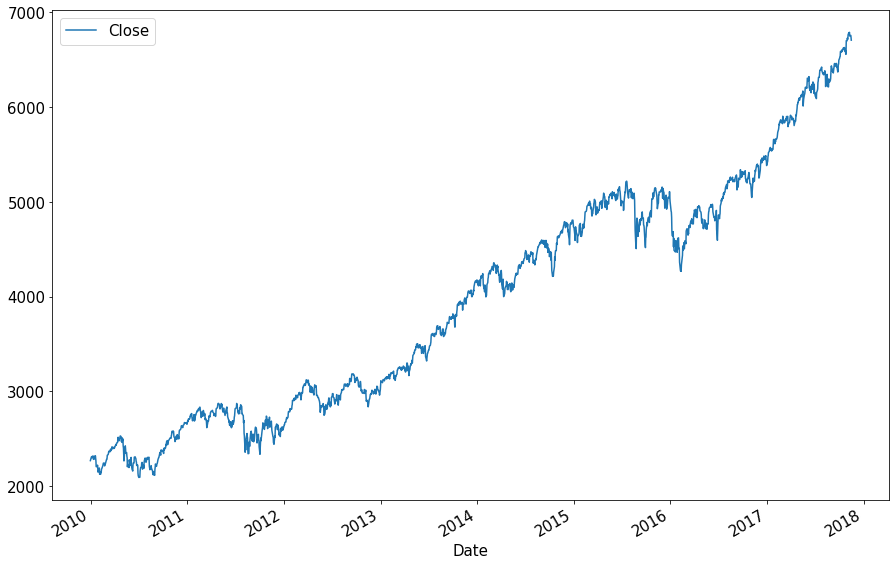

In [709]:
ax = nasdaq_df.plot(y=["Close"])

We can also plot the returns for all the markets.

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f8d5b7b0470>,
      dtype=object)

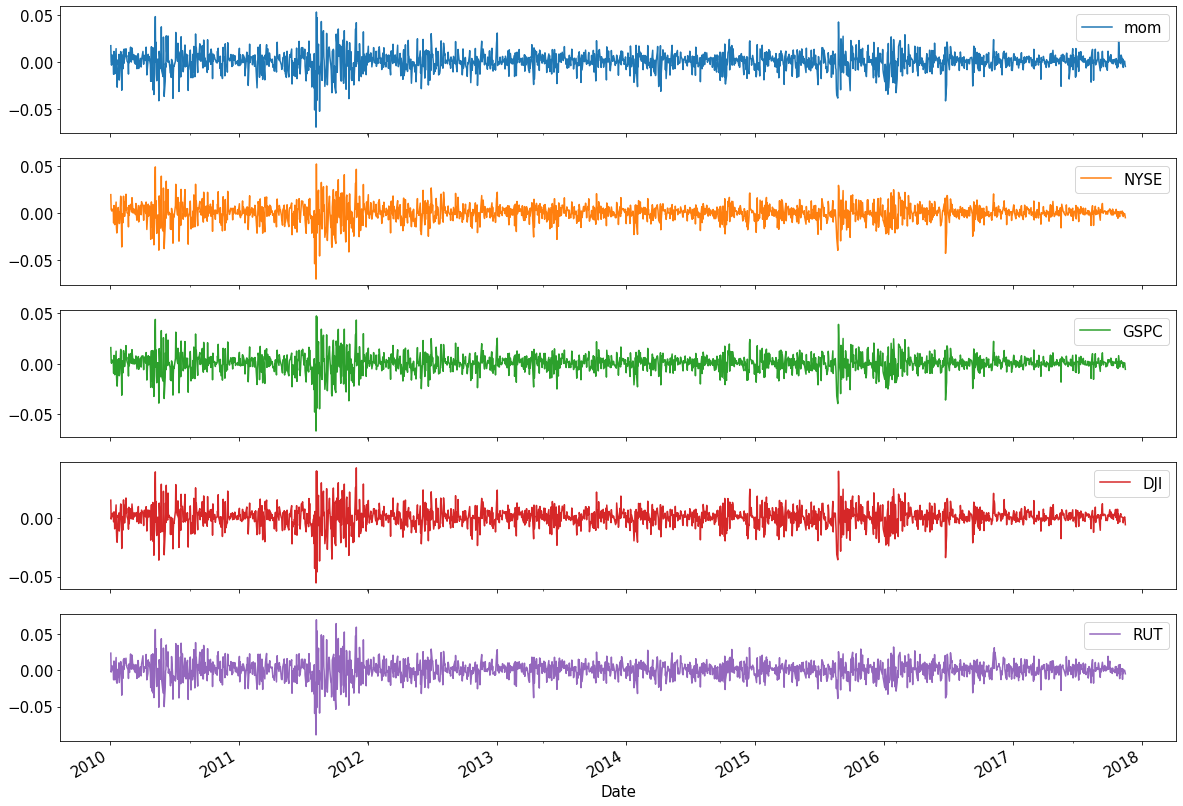

In [710]:
nasdaq_df.plot(y=["mom","NYSE","GSPC","DJI","RUT"], subplots=True, figsize=(20,15))

We can see that there are some common trends.

One example is the big oscillation we can observe between 2011 and 2012

---

Another interesting aspect to look into is the comparison of Nasdaq return among the different years.

As for different years we may have a different number of data points, here we compare only the years that have the same amount of data points and for which the amount corresponds to the maximum.

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f8d5b5b7438>,
      dtype=object)

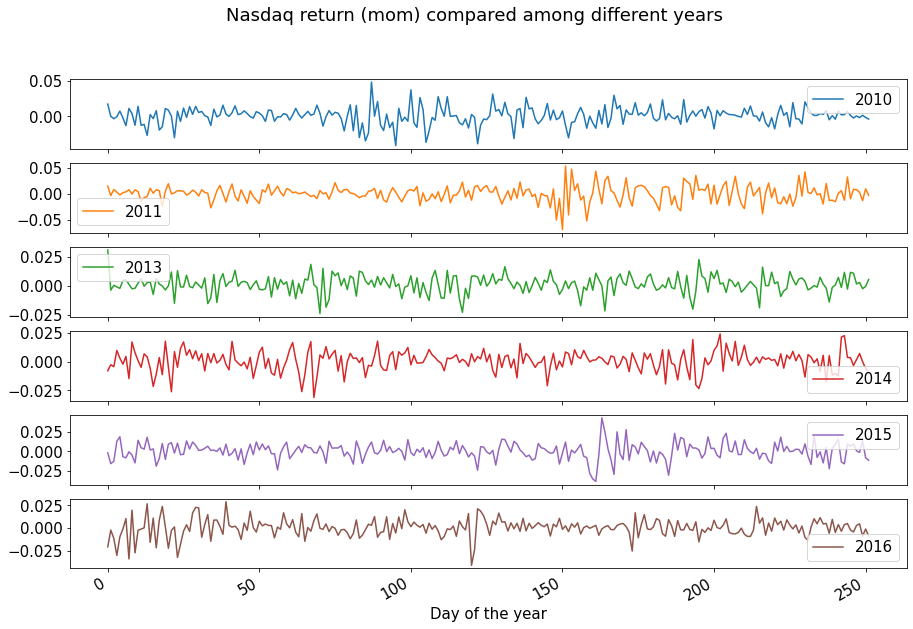

In [711]:
groups = nasdaq_df["mom"].groupby(pd.Grouper(freq='A'))

max_size = 0
for _, group in groups:
    if group.values.shape[0] > max_size:
        max_size = group.values.shape[0]

years = pd.DataFrame()
for name, group in groups:
    if group.values.shape[0] == max_size:
        years[name.year] = group.values

years.plot(subplots=True, xlabel="Day of the year", title="Nasdaq return (mom) compared among different years")

Apart from some common trends between 2013 and 2014, there are no major similarities between different years.

This gives us an intuition that return depends more on other features rather than time of the year.

---

Here we report also a whisker plot for the return of NASDAQ over the years.

This plot draws a box around the 25th and 75th percentiles of the data that captures the middle 50% of observations. A line is drawn at the 50th percentile (the median) and whiskers are drawn above and below the box to summarize the general extents of the observations. Dots are drawn for outliers outside the whiskers or extents of the data.

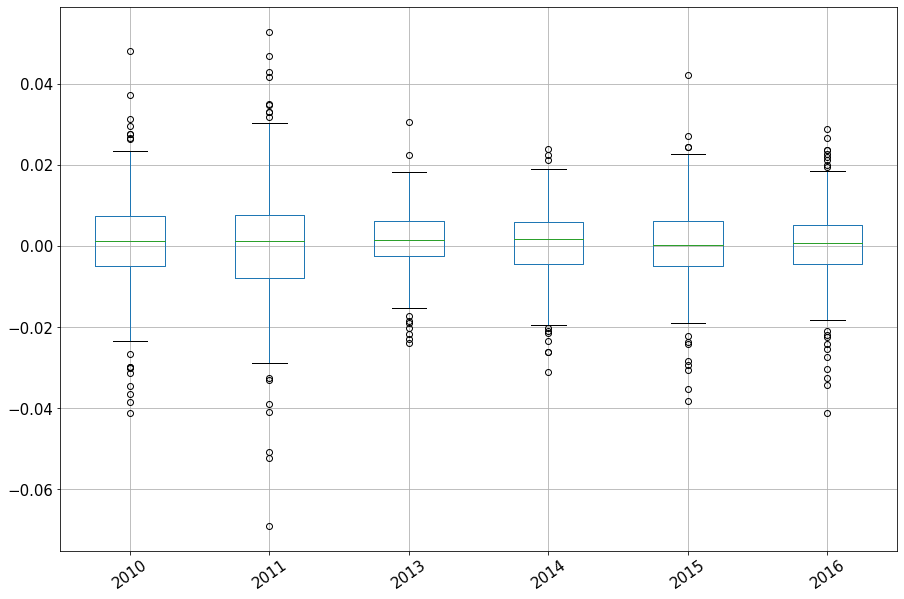

In [712]:
years.boxplot(rot=35)

Another interesting plot to visualize is the distribution of the featrues, we can look at this by plotting an histogram for each feature.

In [713]:
#nasdaq_df.hist(figsize=(30,35), bins=50)

We see that a great part of the features is distributed as a gaussian centered in 0.

---

## 4 - Splitting the data: training, validation and test

As already mentioned, our dataset represents a time series. Therefore, random or stratified train/test split strategies cannot be used as they would not enable the machine learning algorithm to benefit from the fact that the data are temporally correlated with each other.

Given this considerations, the only possibility we have is to split the dataset in the most traditional way:

*   The first 60% of the entries will form the **training set**
*   The subsequent 20% will form the **validation set**
*   The last 20% will form the **test set**

Before performing the split we also compute the target vector, for each entry, the target is 1 if there is an increase in the Close price in the following entry and 0 otherwise.

$$ Target_{t} = \begin{cases} 1, & \mbox{if } Close_{t+1}>Close_{t} \\ 0, & \mbox{else} \end{cases}$$

In [714]:
target_df =  nasdaq_df["Close"].shift(-1) - nasdaq_df["Close"]
target = np.where(target_df.values > 0, 1, 0)
target = target[:-1] # We have to remove the last value as we have no target for it

target.shape

(1983,)

In [715]:
nasdaq_df = nasdaq_df.iloc[:-1,:] # We have to remove the last value as we have no target for it

nasdaq_train = nasdaq_df[:int(nasdaq_df.shape[0]*0.6)]
nasdaq_train_target = target[:int(target.shape[0]*0.6)]

nasdaq_val = nasdaq_df[int(nasdaq_df.shape[0]*0.6):int(nasdaq_df.shape[0]*0.8)]
nasdaq_val_target = target[int(target.shape[0]*0.6):int(target.shape[0]*0.8)]

nasdaq_test =  nasdaq_df[int(nasdaq_df.shape[0]*0.8):]
nasdaq_test_target = target[int(target.shape[0]*0.8):]

In [716]:
print(nasdaq_train.shape, nasdaq_train_target.shape,
      nasdaq_val.shape, nasdaq_val_target.shape,
      nasdaq_test.shape, nasdaq_test_target.shape)

(1189, 83) (1189,) (397, 83) (397,) (397, 83) (397,)


The sets are still in the form of a time series. We will procede to make it suitable for a supervised learning classical task in [this section](#transforming_the_dataset)

Given the nature of the data it is very difficult to split the dataset properly. This is because the data in the time series is closely correlated with each other and with time. Certain features refer to timesteps that go back even 200 days in the data (like EMA_200).

Therefore it is impossible to ensure that the training, validation and test set will be independent between each other. Our evaluations will always be a bit biased. Note that this is caused by the fact that the data we are analysing is a multivariate time series and by the fact that some features refer to previous timesteps.

To ensure the least interdependence between the sets we split them in the shown way. Only after this split we will proceed to build the superviesed learning dataset. Therefore for each set the first $n-1$ targets (where $n$ is the number of training days considered for the prediction) will not be used, as those are the targets that come from input that is partially of other sets or is not available.

---

Furthermore, we can look at the proportion of the target values in each set:

In [717]:
def subset_proportions(subset):
    props = {}
    for value in set(subset):
        data_value = [i for i in subset if i==value]
        props[value] = len(data_value) / len(subset)
    return props

   
compare_props = pd.DataFrame({
    "Overall": subset_proportions(target),
    "Train": subset_proportions(nasdaq_train_target),
    "Validation": subset_proportions(nasdaq_val_target),
    "Test" : subset_proportions(nasdaq_test_target),
})

compare_props

,Overall,Train,Validation,Test
0,0.439738,0.439024,0.463476,0.418136
1,0.560262,0.560976,0.536524,0.581864


We can see that they are pretty balanced. Each class is well represented.

All the three sets of data mantain the proportions of each class similar to the original proportions in the full dataset.

## 5 - Correlations

Now that we have split the dataset we can use our training and validation sets to gain some insights on the correlation of the features.

Let's use nasdaq_train_val for this objective.

In [718]:
nasdaq_train_val = nasdaq_df[:int(nasdaq_df.shape[0]*0.8)]
nasdaq_train_val_target = target[:int(target.shape[0]*0.8)]

nasdaq_train_val.shape, nasdaq_train_val_target.shape

((1586, 83), (1586,))

By doing this we ensure no data leakage between the training/validation sets and test set. The results on the test set are thus a fair evaluation the algorithm's performance.

---

### Autocorrelation

As we said our dataset contains a time series.

Therefore we can analyse the time series of various features.

Let's build the series for:

*   Close, the close price of the Nasdaq market
*   mom, Nasdaq return

In [719]:
close_series = pd.Series(nasdaq_train_val["Close"])

return_series = pd.Series(nasdaq_train_val["mom"].bfill()) # We temporarly backward fill the only NaN in the mom column as we need all the values for plotting

Now that we have mapped the two series to the pandas Series object we can look at their autocorrelation plots.

The autocorrelation plot is a way of measuring and explaining the internal association between observations in a time series. We can check how strong an internal correlation is in an given amount of time.

The autocorrelation plot shows how much the value of the time series is correlated with itself $n$ timesteps in the past. $n$ is called lag.

The dotted lines are just above and below the first quartile, or within the 95% confidence interval. This will indicate the significance of the correlation. If the line is above or below the dotted line, not in between, we can say that the correlation is significant, and that the close value is correlated to time.

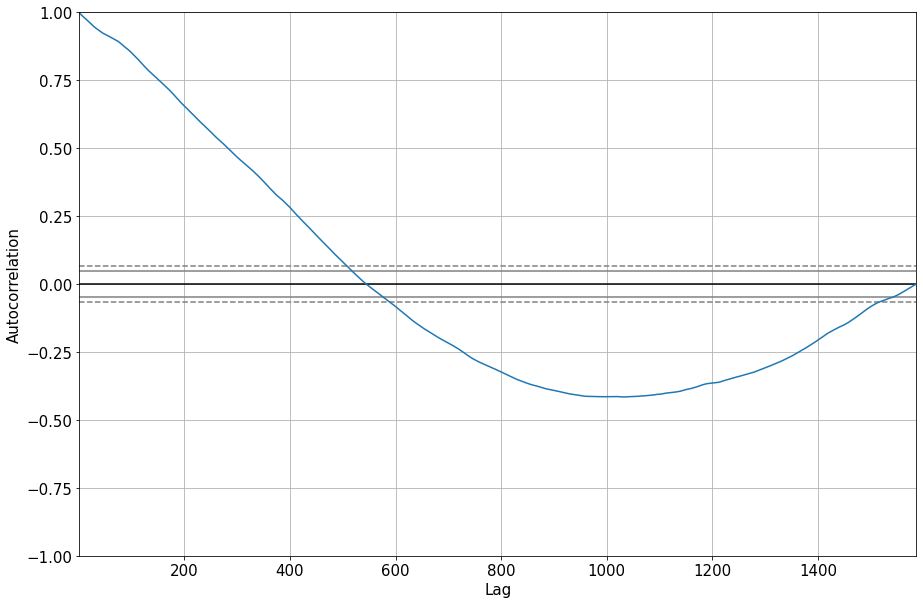

In [720]:
from pandas.plotting import autocorrelation_plot

autocorrelation_plot(close_series)

In this plot we can see that the close price is highly correlated with itself in the first part of the graph. The correlation decreases with the increase of the lag as we can expect.
This is intuitive as the close price is a variable that we expect to be correlated with itself for small lags.

There is an interesting negative correlation in the second half of the plot. This could suggest a trend of stock markets to rebalance themselves every three-four years. This could also be an effect of the econimic crisis.

This suggestes that there is an association between time and close price.

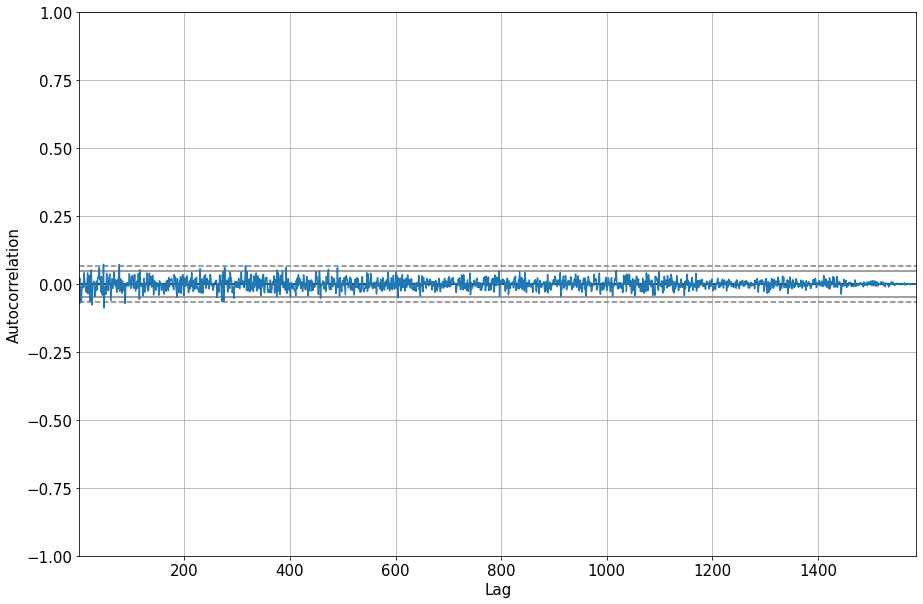

In [721]:
autocorrelation_plot(return_series)

This plot shows that the return of NASDAQ is not correlated with itself in the past and therefore we will rely on other features to predict our target.

---

Now let's look at the correlation among the features.

First we will plot the correlation matrix among features of the same category.

In [722]:
primitive_indices = ["Close","mom"]

These are the features that resemble our target, therefore we will see the correlation of these with all the other features grouped by cathegory

### Technical indicators

Let's see the correlation between primitive features and technincal indicators.

In [723]:
technical_indeces.remove("mom")
correlation_matrix = nasdaq_train_val[primitive_indices + technical_indeces].corr()
correlation_matrix

,Close,mom,Volume,mom1,mom2,mom3,ROC_5,ROC_10,ROC_15,ROC_20,EMA_10,EMA_20,EMA_50,EMA_200
Close,1.000000,0.013161,-0.011268,0.012950,0.013817,0.011290,0.030924,0.038706,0.043148,0.041405,0.998540,0.996993,0.993306,0.979900
mom,0.013161,1.000000,-0.108134,-0.016773,0.022035,-0.069554,0.422672,0.285440,0.240468,0.202192,-0.015352,-0.021869,-0.016100,-0.017654
Volume,-0.011268,-0.108134,1.000000,-0.003307,0.033640,0.013937,-0.037671,-0.013203,-0.027852,-0.037264,-0.006736,-0.006284,-0.008496,-0.012860
mom1,0.012950,-0.016773,-0.003307,1.000000,-0.016750,0.022016,0.422485,0.286032,0.245355,0.202210,-0.010861,-0.017482,-0.014904,-0.017184
mom2,0.013817,0.022035,0.033640,-0.016750,1.000000,-0.016665,0.464974,0.294239,0.254517,0.217310,-0.005034,-0.014936,-0.013651,-0.017302
mom3,0.011290,-0.069554,0.013937,0.022016,-0.016665,1.000000,0.426354,0.271127,0.237996,0.190382,-0.001915,-0.012700,-0.013477,-0.017970
ROC_5,0.030924,0.422672,-0.037671,0.422485,0.464974,0.426354,1.000000,0.651907,0.557919,0.461700,-0.014659,-0.035387,-0.032125,-0.039907
ROC_10,0.038706,0.285440,-0.013203,0.286032,0.294239,0.271127,0.651907,1.000000,0.776096,0.675935,-0.004512,-0.033586,-0.045388,-0.063019
ROC_15,0.043148,0.240468,-0.027852,0.245355,0.254517,0.237996,0.557919,0.776096,1.000000,0.827647,0.004394,-0.025975,-0.052894,-0.077817
ROC_20,0.041405,0.202192,-0.037264,0.202210,0.217310,0.190382,0.461700,0.675935,0.827647,1.000000,0.007143,-0.020521,-0.058151,-0.093433


In [724]:
correlation_matrix["mom"].sort_values(ascending=False)

mom        1.000000
ROC_5      0.422672
ROC_10     0.285440
ROC_15     0.240468
ROC_20     0.202192
mom2       0.022035
Close      0.013161
EMA_10    -0.015352
EMA_50    -0.016100
mom1      -0.016773
EMA_200   -0.017654
EMA_20    -0.021869
mom3      -0.069554
Volume    -0.108134
Name: mom, dtype: float64

In [725]:
correlation_matrix["Close"].sort_values(ascending=False)

Close      1.000000
EMA_10     0.998540
EMA_20     0.996993
EMA_50     0.993306
EMA_200    0.979900
ROC_15     0.043148
ROC_20     0.041405
ROC_10     0.038706
ROC_5      0.030924
mom2       0.013817
mom        0.013161
mom1       0.012950
mom3       0.011290
Volume    -0.011268
Name: Close, dtype: float64

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f8d5b1ca128>,
      dtype=object)

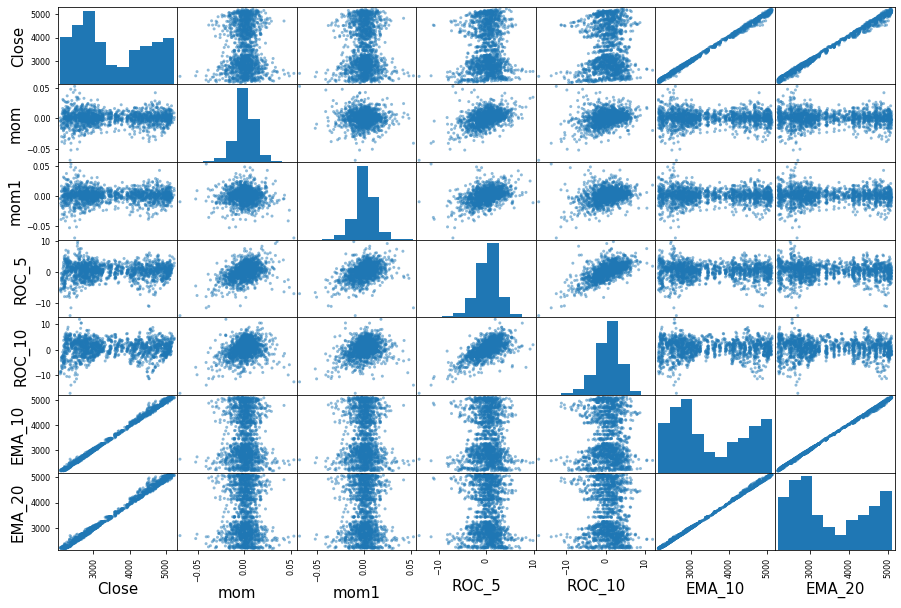

In [726]:
from pandas.plotting import scatter_matrix

attributes = ["Close", "mom","mom1", "ROC_5", "ROC_10", "EMA_10","EMA_20"]
scatter_matrix(nasdaq_train_val[attributes])

We see that the close price is very correlated with all the EMA features and the return closely correlates with the ROC features.

### Economic indicators

In [727]:
correlation_matrix = nasdaq_train_val[primitive_indices + economic_indices].corr()
correlation_matrix

,Close,mom,DTB4WK,DTB3,DTB6,DGS5,DGS10,DAAA,DBAA,TE1,TE2,TE3,TE5,TE6,DE1,DE2,DE4,DE5,DE6,CTB3M,CTB6M,CTB1Y
Close,1.000000,0.013161,-0.140384,-0.146324,0.084550,0.046720,-0.321696,-0.371742,-0.426038,-0.308606,-0.307973,-0.333942,-0.038684,0.277159,-0.195090,-0.203514,-0.454384,-0.423785,-0.421950,0.018982,0.016861,0.008552
mom,0.013161,1.000000,0.000515,0.000126,-0.020002,0.002118,0.009458,0.008784,0.004862,0.009435,0.009508,0.012547,-0.000833,-0.032349,-0.008831,-0.006234,0.008046,0.004996,0.004919,0.016548,0.106094,0.126057
DTB4WK,-0.140384,0.000515,1.000000,0.907245,0.792518,0.089288,0.079501,0.131336,0.271920,-0.020307,-0.018317,-0.044046,-0.045227,0.243808,0.382639,0.316265,0.162926,0.186707,0.183222,0.042106,0.071746,0.078514
DTB3,-0.146324,0.000126,0.907245,1.000000,0.904716,0.138286,0.114980,0.167665,0.337785,0.024558,0.007344,-0.026125,0.379140,0.516519,0.464320,0.368843,0.214367,0.245005,0.259279,0.056368,0.086419,0.093466
DTB6,0.084550,-0.020002,0.792518,0.904716,1.000000,0.197716,0.059810,0.108481,0.312782,-0.019298,-0.037864,-0.095966,0.405232,0.784668,0.543922,0.410653,0.174139,0.229058,0.244585,0.083578,0.102466,0.109504
DGS5,0.046720,0.002118,0.089288,0.138286,0.197716,1.000000,0.889013,0.755180,0.625489,0.882719,0.879934,0.855730,0.132008,0.223660,-0.223847,-0.318462,0.618785,0.630060,0.630533,0.140037,0.216721,0.237949
DGS10,-0.321696,0.009458,0.079501,0.114980,0.059810,0.889013,1.000000,0.928366,0.791311,0.995015,0.994185,0.987863,0.098187,0.014301,-0.217353,-0.218184,0.811403,0.803266,0.800857,0.184384,0.284083,0.318466
DAAA,-0.371742,0.008784,0.131336,0.167665,0.108481,0.755180,0.928366,1.000000,0.922319,0.917982,0.916364,0.908858,0.109278,0.039010,-0.053366,0.097033,0.939918,0.932791,0.929789,0.292802,0.435856,0.486958
DBAA,-0.426038,0.004862,0.271920,0.337785,0.312782,0.625489,0.791311,0.922319,1.000000,0.766456,0.759956,0.740400,0.204044,0.220998,0.336657,0.424033,0.989780,0.995295,0.995851,0.347553,0.510346,0.567914
TE1,-0.308606,0.009435,-0.020307,0.024558,-0.019298,0.882719,0.995015,0.917982,0.766456,1.000000,0.998969,0.995202,0.103003,-0.010048,-0.256278,-0.250472,0.797512,0.786972,0.784904,0.180724,0.277754,0.311564


In [728]:
correlation_matrix["mom"].sort_values(ascending=False)

mom       1.000000
CTB1Y     0.126057
CTB6M     0.106094
CTB3M     0.016548
Close     0.013161
TE3       0.012547
TE2       0.009508
DGS10     0.009458
TE1       0.009435
DAAA      0.008784
DE4       0.008046
DE5       0.004996
DE6       0.004919
DBAA      0.004862
DGS5      0.002118
DTB4WK    0.000515
DTB3      0.000126
TE5      -0.000833
DE2      -0.006234
DE1      -0.008831
DTB6     -0.020002
TE6      -0.032349
Name: mom, dtype: float64

In [729]:
correlation_matrix["Close"].sort_values(ascending=False)

Close     1.000000
TE6       0.277159
DTB6      0.084550
DGS5      0.046720
CTB3M     0.018982
CTB6M     0.016861
mom       0.013161
CTB1Y     0.008552
TE5      -0.038684
DTB4WK   -0.140384
DTB3     -0.146324
DE1      -0.195090
DE2      -0.203514
TE2      -0.307973
TE1      -0.308606
DGS10    -0.321696
TE3      -0.333942
DAAA     -0.371742
DE6      -0.421950
DE5      -0.423785
DBAA     -0.426038
DE4      -0.454384
Name: Close, dtype: float64

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f8d5b1c3c88>,
      dtype=object)

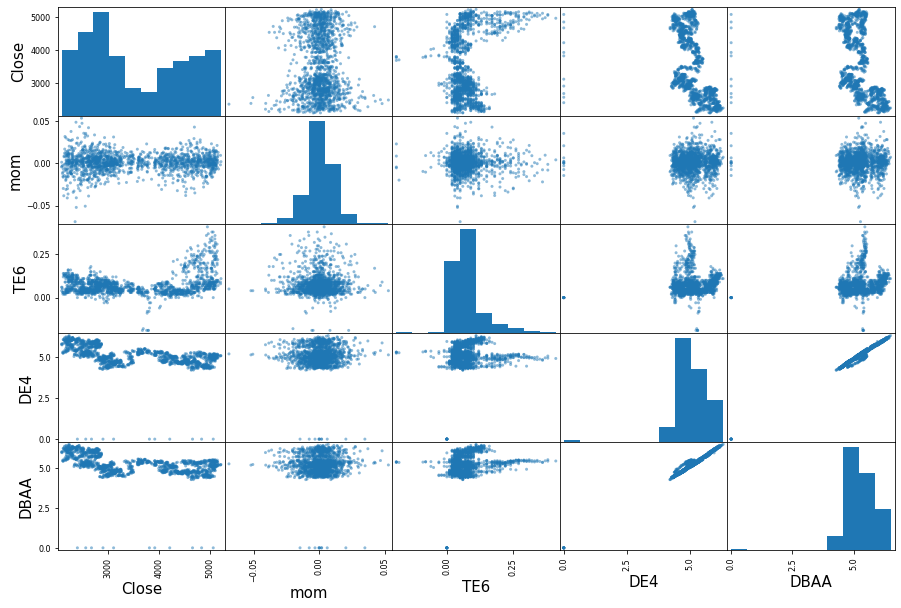

In [730]:
attributes = ["Close", "mom", "TE6", "DE4", "DBAA"]
scatter_matrix(nasdaq_train_val[attributes])

We can see many otther significant correlations in the data

### Word indices

In [731]:
correlation_matrix = nasdaq_train_val[primitive_indices + word_indices].corr()
correlation_matrix

,Close,mom,GSPC,DJI,NYSE,RUT,HSI,SSEC,FCHI,FTSE,GDAXI
Close,1.000000,0.013161,0.008516,0.005252,0.003352,-0.002501,0.009781,0.038348,0.019246,-0.000397,0.010870
mom,0.013161,1.000000,0.957004,0.910326,0.920707,0.934170,0.227250,0.160957,0.624372,0.615035,0.621112
GSPC,0.008516,0.957004,1.000000,0.977023,0.980936,0.920757,0.212040,0.141986,0.663368,0.655497,0.650377
DJI,0.005252,0.910326,0.977023,1.000000,0.958752,0.874119,0.204410,0.131946,0.667839,0.662310,0.658623
NYSE,0.003352,0.920707,0.980936,0.958752,1.000000,0.916206,0.251728,0.156987,0.697693,0.690107,0.675278
RUT,-0.002501,0.934170,0.920757,0.874119,0.916206,1.000000,0.190366,0.128614,0.594675,0.584461,0.595792
HSI,0.009781,0.227250,0.212040,0.204410,0.251728,0.190366,1.000000,0.537265,0.375158,0.416957,0.366131
SSEC,0.038348,0.160957,0.141986,0.131946,0.156987,0.128614,0.537265,1.000000,0.174730,0.207577,0.162856
FCHI,0.019246,0.624372,0.663368,0.667839,0.697693,0.594675,0.375158,0.174730,1.000000,0.889692,0.933846
FTSE,-0.000397,0.615035,0.655497,0.662310,0.690107,0.584461,0.416957,0.207577,0.889692,1.000000,0.859446


In [732]:
correlation_matrix["mom"].sort_values(ascending=False)

mom      1.000000
GSPC     0.957004
RUT      0.934170
NYSE     0.920707
DJI      0.910326
FCHI     0.624372
GDAXI    0.621112
FTSE     0.615035
HSI      0.227250
SSEC     0.160957
Close    0.013161
Name: mom, dtype: float64

In [733]:
correlation_matrix["Close"].sort_values(ascending=False)

Close    1.000000
SSEC     0.038348
FCHI     0.019246
mom      0.013161
GDAXI    0.010870
HSI      0.009781
GSPC     0.008516
DJI      0.005252
NYSE     0.003352
FTSE    -0.000397
RUT     -0.002501
Name: Close, dtype: float64

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f8d52fdf710>,
      dtype=object)

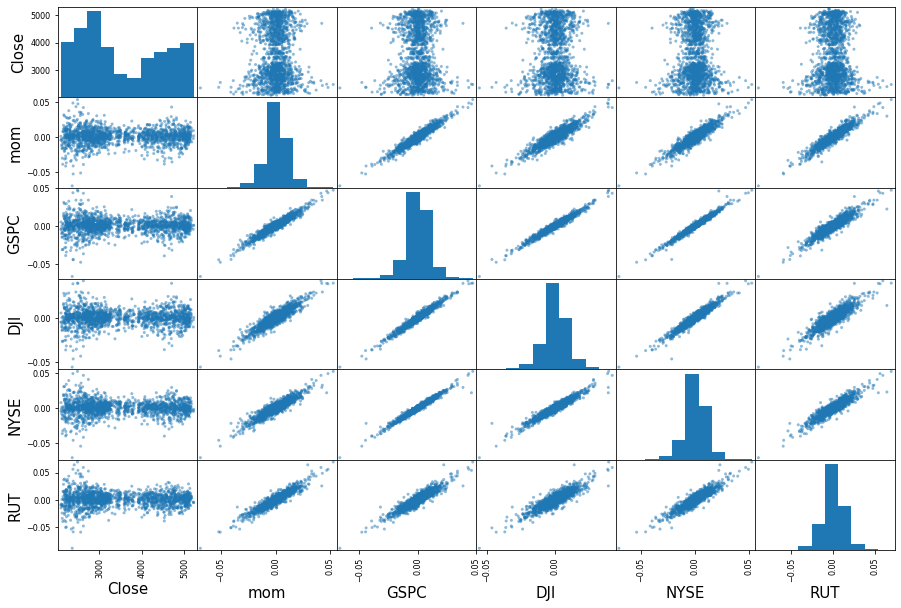

In [734]:
attributes = primitive_indices + word_indices[:4]
scatter_matrix(nasdaq_train_val[attributes])

Here we can se that all the returns from the stock markets are very closely correlated with each other.

### All features

Now we look at the correlation between the primitive features and all other features.

In [735]:
correlation_matrix = nasdaq_train_val.corr()
correlation_matrix

,day_of_week,Close,Volume,mom,mom1,mom2,mom3,ROC_5,ROC_10,ROC_15,ROC_20,EMA_10,EMA_20,EMA_50,EMA_200,DTB4WK,DTB3,DTB6,DGS5,DGS10,DAAA,DBAA,TE1,TE2,TE3,TE5,TE6,DE1,DE2,DE4,DE5,DE6,CTB3M,CTB6M,CTB1Y,Oil,Brent,WIT-oil,Gold,gold-F,...,silver-F,copper-F,wheat-F,GSPC,DJI,NYSE,RUT,HSI,SSEC,FCHI,FTSE,GDAXI,JPY,GBP,CAD,CNY,AUD,NZD,CHF,EUR,Dollar index,Dollar index-F,XOM,JPM,AAPL,MSFT,GE,JNJ,WFC,AMZN,CAC-F,FTSE-F,DAX-F,HSI-F,Nikkei-F,KOSPI-F,NASDAQ-F,DJI-F,S&P-F,RUSSELL-F
day_of_week,1.000000,-0.012143,0.036965,-0.000538,0.012834,0.015087,0.009849,0.000494,0.000615,-0.006653,-0.007641,-0.014136,-0.012308,-0.009594,-0.010995,0.001967,-0.038527,-0.030977,0.008916,0.021236,0.045196,0.053371,0.021102,0.025554,0.025996,-0.095834,-0.051262,0.027785,0.053733,0.059983,0.058942,0.054336,-0.122205,0.040197,0.066030,0.002934,0.038427,0.006047,0.114516,-0.017844,...,0.015526,0.040392,0.007072,0.004454,0.000514,0.014728,0.011159,0.054141,0.017566,0.025803,0.018223,0.006300,0.035487,0.039729,-0.028495,0.013418,-0.005112,0.043289,-0.022606,0.013199,0.026536,0.016359,-0.022330,0.001860,-0.109330,0.009357,0.025402,-0.037219,0.021702,0.047504,0.044035,0.035365,0.010408,0.049752,0.031316,-0.022613,-0.004584,0.026998,0.024065,0.003713
Close,-0.012143,1.000000,-0.011268,0.013161,0.012950,0.013817,0.011290,0.030924,0.038706,0.043148,0.041405,0.998540,0.996993,0.993306,0.979900,-0.140384,-0.146324,0.084550,0.046720,-0.321696,-0.371742,-0.426038,-0.308606,-0.307973,-0.333942,-0.038684,0.277159,-0.195090,-0.203514,-0.454384,-0.423785,-0.421950,0.018982,0.016861,0.008552,-0.030307,-0.031793,-0.029138,-0.007477,-0.021682,...,-0.005397,-0.020317,-0.012872,0.008516,0.005252,0.003352,-0.002501,0.009781,0.038348,0.019246,-0.000397,0.010870,0.006151,0.010778,0.013959,0.067556,-0.025396,-0.024885,0.014106,-0.009906,0.018261,0.018401,-0.012332,0.018136,-0.009278,0.040555,0.007187,0.018140,0.005241,0.025894,0.015351,-0.005074,0.010063,0.003176,0.016234,-0.011907,0.011671,0.001422,0.007044,0.008845
Volume,0.036965,-0.011268,1.000000,-0.108134,-0.003307,0.033640,0.013937,-0.037671,-0.013203,-0.027852,-0.037264,-0.006736,-0.006284,-0.008496,-0.012860,0.001818,0.003246,0.013207,-0.007798,-0.001690,0.020361,0.036153,-0.001877,-0.002054,-0.003743,0.003711,0.019164,0.043770,0.060158,0.035495,0.036909,0.036763,-0.017014,-0.004974,0.011748,-0.071829,-0.062738,-0.074112,0.078118,0.035804,...,0.031609,-0.046376,-0.017123,-0.106289,-0.111014,-0.104246,-0.080054,-0.037151,-0.045307,-0.096902,-0.114208,-0.083199,-0.031255,-0.048548,0.067724,0.023994,-0.061822,-0.031725,-0.003001,-0.036053,0.034303,0.032085,-0.068639,-0.053999,-0.064177,-0.051640,-0.085418,-0.060710,-0.059079,-0.065067,-0.077432,-0.099410,-0.082091,-0.045228,-0.016217,-0.019405,-0.092936,-0.076953,-0.084694,-0.088742
mom,-0.000538,0.013161,-0.108134,1.000000,-0.016773,0.022035,-0.069554,0.422672,0.285440,0.240468,0.202192,-0.015352,-0.021869,-0.016100,-0.017654,0.000515,0.000126,-0.020002,0.002118,0.009458,0.008784,0.004862,0.009435,0.009508,0.012547,-0.000833,-0.032349,-0.008831,-0.006234,0.008046,0.004996,0.004919,0.016548,0.106094,0.126057,0.338667,0.359178,0.355937,-0.013443,0.024722,...,0.163477,0.377114,0.136444,0.957004,0.910326,0.920707,0.934170,0.227250,0.160957,0.624372,0.615035,0.621112,0.079560,0.131143,-0.249093,-0.052187,0.538462,0.456287,-0.009017,0.247549,-0.217677,-0.212775,0.664104,0.709344,0.642520,0.681261,0.710741,0.624293,0.733060,0.600249,0.604830,0.607417,0.611141,0.246801,0.200413,0.232341,0.962628,0.883515,0.933641,0.907180
mom1,0.012834,0.012950,-0.003307,-0.016773,1.000000,-0.016750,0.022016,0.422485,0.286032,0.245355,0.202210,-0.010861,-0.017482,-0.014904,-0.017184,-0.011544,-0.009034,-0.021269,-0.000718,0.008204,0.014359,0.013790,0.009388,0.009242,0.011498,0.003939,-0.022102,0.000650,0.009860,0.017495,0.015139,0.015184,0.026916,-0.018016,-0.017999,0.018083,0.021755,0.005666,-0.002883,-0.010106,...,0.054499,0.018879,-0.005973,-0.045329,-0.047410,-0.037379,-0.056509,0.433049,0.176511,0.14178

In [736]:
correlation_matrix["mom"].sort_values(ascending=False)

mom               1.000000
NASDAQ-F          0.962628
GSPC              0.957004
RUT               0.934170
S&P-F             0.933641
                    ...   
mom3             -0.069554
Volume           -0.108134
Dollar index-F   -0.212775
Dollar index     -0.217677
CAD              -0.249093
Name: mom, Length: 83, dtype: float64

In [737]:
correlation_matrix["Close"].sort_values(ascending=False)

Close      1.000000
EMA_10     0.998540
EMA_20     0.996993
EMA_50     0.993306
EMA_200    0.979900
             ...   
DAAA      -0.371742
DE6       -0.421950
DE5       -0.423785
DBAA      -0.426038
DE4       -0.454384
Name: Close, Length: 83, dtype: float64

As we can see the return is very correlated with the returns of other stock markets and with its and their futures. We can also see a significant negative correlation with the relative change in the U.S dollar index.

The close price is very correlated with the exponential moving average and negatively correlated with economic features.

## 6 - Data transformations

Now that we have explored the attributes and their correlation we can transform our data to prepare it for the machine learning algorithms.

<a name="missing_values"></a>

### Missing values

In our dataset there are some missing values. Therefore we need to define a strategy to treat them.

Given the fact that we are working with time series we use the interpolation function provided by pandas, which interpolates the missing values using the time index.

Then to fill the remaining missing values in the first rows of the dataset, we perform backwards filling using pandas' `bfill()` function. This function propagates backwards the first valid value to fill the remaining missing values.

In [738]:
nasdaq_train = nasdaq_train.interpolate(method='time')
nasdaq_train = nasdaq_train.bfill()

nasdaq_train_val = nasdaq_train_val.interpolate(method='time')
nasdaq_train_val = nasdaq_train_val.bfill()

nasdaq_val = nasdaq_val.interpolate(method='time')
nasdaq_val = nasdaq_val.bfill()

nasdaq_test = nasdaq_test.interpolate(method='time')
nasdaq_test = nasdaq_test.bfill()

<a name="cathegorical_values"></a>

### Categorical features

In the dataset we have just one categorical feature which is "day_of_week"

It is already expressed as an int, with the following mapping:

*   0 -> Monday
*   1 -> Tuesday
*   2 -> Wednesday
*   3 -> Thursday
*   4 -> Friday

In this case we do not need to map it to a one-hot encoding, as we want the alogrithm to benefit from the similarity given from this encoding of the days of the week.

Note that we never have data on Saturdays and Sundays, as in those days the stock market is closed.




### Feature scaling

Finally, we want to standardise our features as they have various different ranges.

To do this we perform standard scaling of the features.

In [739]:
from sklearn.preprocessing import StandardScaler

nasdaq_train = pd.DataFrame(data=StandardScaler().fit_transform(nasdaq_train), columns=nasdaq_train.columns, index=nasdaq_train.index)

nasdaq_train_val = pd.DataFrame(data=StandardScaler().fit_transform(nasdaq_train_val), columns=nasdaq_train_val.columns, index=nasdaq_train_val.index)

nasdaq_val = pd.DataFrame(data=StandardScaler().fit_transform(nasdaq_val), columns=nasdaq_val.columns, index=nasdaq_val.index)

nasdaq_test = pd.DataFrame(data=StandardScaler().fit_transform(nasdaq_test), columns=nasdaq_test.columns, index=nasdaq_test.index)

<a name="transforming_the_dataset"></a>

### Dynamic window, transfrming the dataset for supervised learning

Now that we have prepared our data, we can build the dataset fro our prediction task.

To do this we will make use of the following function:

In [740]:
# from https://machinelearningmastery.com/convert-time-series-supervised-learning-problem-python/

def series_to_supervised(data, n_in, dropnan=True):
    """
    Frame a time series as a supervised learning dataset.
    Arguments:
        data: Sequence of observations as a list or NumPy array.
        n_in: Number of lag observations as input (n).
        dropnan: Boolean whether or not to drop rows with NaN values.
    Returns:
        Pandas DataFrame of series framed for supervised learning.
    """
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in - 1, -1, -1):
        cols.append(df.shift(i))
        if i != 0:
            names += [f'{feature}(t-{i})' for feature in nasdaq_df.columns]
        else:
            names += [f'{feature}(t)' for feature in nasdaq_df.columns]

    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

This function takes as input the time series dataset and outputs a DataFrame containing for each row $n * 83$ values. This values are the values of the features for all the $n$ previous training days.

As mentioned before for each dataset we drop the first $n-1$ lines as they would have inputs for which we don't have all the data. This is done by setting the *dropnan* flag.

---

Now we select the number of previous training days that we want to consider for our prediction.

With use the value of $60$ as it is the one chosen by the authors of the paper.

In [741]:
n = 60

Now let's use the function described above to obtain our new dataset.

In [742]:
nasdaq_train_y = nasdaq_train_target[n-1:]  # We drop the first n-1 targets as we do not have the data to predict them
nasdaq_train_X = series_to_supervised(nasdaq_train.values, n)

nasdaq_train_X

,day_of_week(t-59),Close(t-59),Volume(t-59),mom(t-59),mom1(t-59),mom2(t-59),mom3(t-59),ROC_5(t-59),ROC_10(t-59),ROC_15(t-59),ROC_20(t-59),EMA_10(t-59),EMA_20(t-59),EMA_50(t-59),EMA_200(t-59),DTB4WK(t-59),DTB3(t-59),DTB6(t-59),DGS5(t-59),DGS10(t-59),DAAA(t-59),DBAA(t-59),TE1(t-59),TE2(t-59),TE3(t-59),TE5(t-59),TE6(t-59),DE1(t-59),DE2(t-59),DE4(t-59),DE5(t-59),DE6(t-59),CTB3M(t-59),CTB6M(t-59),CTB1Y(t-59),Oil(t-59),Brent(t-59),WIT-oil(t-59),Gold(t-59),gold-F(t-59),...,silver-F(t),copper-F(t),wheat-F(t),GSPC(t),DJI(t),NYSE(t),RUT(t),HSI(t),SSEC(t),FCHI(t),FTSE(t),GDAXI(t),JPY(t),GBP(t),CAD(t),CNY(t),AUD(t),NZD(t),CHF(t),EUR(t),Dollar index(t),Dollar index-F(t),XOM(t),JPM(t),AAPL(t),MSFT(t),GE(t),JNJ(t),WFC(t),AMZN(t),CAC-F(t),FTSE-F(t),DAX-F(t),HSI-F(t),Nikkei-F(t),KOSPI-F(t),NASDAQ-F(t),DJI-F(t),S&P-F(t),RUSSELL-F(t)
59,0.694812,-1.230191,1.972537,1.468759,1.465999,1.463239,1.461329,0.741663,0.062238,-0.899760,-1.248399,-1.178647,-1.226911,-1.239294,-1.139481,-0.417058,-0.341011,1.470037,2.319381,1.958575,1.544304,1.591357,2.017239,2.024582,1.894549,0.175506,2.825131,0.266273,-0.601609,1.533614,1.664089,1.657155,-0.658833,-0.376463,-0.092437,1.585042,-0.109109,0.044542,0.143076,0.249459,...,1.034073,2.700194,-0.046425,0.505453,0.403469,0.729437,0.296473,0.728862,1.811800,0.209258,0.116714,0.434282,0.503068,2.421866,-1.444712,-0.035211,1.980563,1.145908,-0.431866,0.815045,-0.857203,-0.944324,0.976674,-0.222841,0.311517,-0.202867,0.187240,0.753761,-0.266679,-0.024503,0.209646,0.251675,0.586614,0.444673,0.578560,0.007352,0.338687,0.265428,0.386509,0.037158
60,-1.449129,-1.171933,1.972537,1.468759,1.465999,1.463239,1.461329,0.741663,0.062238,-0.899760,-1.248399,-1.178647,-1.226911,-1.239294,-1.139481,-0.217909,0.082006,1.113982,2.248310,1.958575,1.575219,1.591357,2.002126,1.994137,1.925322,0.539689,2.006376,0.188761,-0.601609,1.564747,1.633383,1.641934,-0.658833,-0.376463,-0.092437,1.585042,1.900304,1.641817,0.143076,1.565793,...,-0.126833,0.475586,0.930774,-0.050396,0.063605,-0.091396,0.130833,0.535551,0.119423,-0.250495,-0.712821,-0.227081,1.187558,1.490554,-0.652821,0.033141,0.146905,0.289232,0.466664,-0.795043,0.286478,0.299672,-0.360774,-0.370244,0.809488,0.401039,-0.418212,0.090201,-0.530427,0.476570,-0.195586,-0.755197,-0.138436,0.687859,0.645622,0.362411,0.183866,0.200371,0.008399,0.175315
61,-0.734482,-1.171502,0.746560,-0.047147,1.465999,1.463239,1.461329,0.741663,0.062238,-0.899760,-1.248399,-1.178647,-1.226911,-1.239294,-1.139481,-0.616208,-0.129502,0.935954,2.088400,1.839320,1.405187,1.457225,1.911451,1.887579,1.817616,0.903871,2.279294,0.266273,-0.626055,1.440215,1.510560,1.535385,-0.358027,-0.668986,-0.304229,0.144321,0.382992,0.179179,0.154137,0.018523,...,0.562160,-0.165743,-2.310668,-0.377125,-0.556708,-0.200181,-0.588809,-0.546634,-0.549226,-0.254069,0.110221,0.101219,0.526968,1.460500,-1.447973,0.101506,-0.257579,-0.501547,-1.744004,1.251111,-1.072992,-1.176255,-0.124791,0.181215,-0.282147,-1.187308,-0.420266,0.491661,0.487973,-0.332796,-0.342943,-0.339992,-0.260635,-0.544842,-0.166574,-0.321727,-0.517383,-0.623692,-0.398797,-0.602727
62,-0.019835,-1.182807,-0.259552,-0.349450,-0.049254,1.463239,1.461329,0.741663,0.062238,-0.899760,-1.248399,-1.178647,-1.226911,-1.239294,-1.139481,-0.616208,-0.341011,0.579899,2.159471,1.958575,1.497932,1.516840,2.032351,2.024582,1.971482,0.539689,1.733457,0.188761,-0.723838,1.533614,1.587324,1.596270,-0.778271,0.057936,0.245843,0.991175,1.080136,1.035954,0.185673,1.211691,...,1.010477,0.582474,0.616163,0.675991,0.652449,1.097923,0.510244,1.173348,1.061561,1.107267,1.159174,1.013475,1.138858,-1.096399,0.378729,0.052674,0.618802,-0.092978,0.295515,0.882132,-0.792466,-0.838900,0.798544,0.499073,0.174248,-0.351520,0.456452,0.979820,0.426906,-1.456539,1.167468,1.310447,1.132438,1.090374,0.839356,1.392948,-0.235062,0.579874,0.657973,0.487987
63,0.694812,-1.184350,-0.054999,-0.098113,-0.351427,-0.050714,1.461329,0.741663,0.062238,-0.899760,-1.248399,-1.178647,-1.226911,-1.239294,-1.1394

As we can see now our dataset is suited for the classification task.

Let's reshape it into a 3 dimensional array.

In [743]:
nasdaq_train_X = nasdaq_train_X.values
nasdaq_train_X_3D = nasdaq_train_X.reshape(-1, n, nasdaq_train.shape[1])
nasdaq_train_y = nasdaq_train_y.reshape(-1,1)

nasdaq_train_X_3D.shape, nasdaq_train_y.shape

((1130, 60, 83), (1130, 1))

We obtain a training set with 1130 entries.

Each entry has $n * 83$ features, where n represents the number of previous training days considered and 83 is the number of features we have for each day.

---

<a name="train_val"></a>

We also convert the set containing both the training and validation set.

This set will be bigger than the union of the converted train and validation sets. This is because when we convert it we do not need to throw away the first $n-1$ entries of the validation set.

We will use this set for [time series cross validation](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.TimeSeriesSplit.html)

In [744]:
nasdaq_train_val_y = nasdaq_train_val_target[n-1:]
nasdaq_train_val_X = series_to_supervised(nasdaq_train_val.values, n)
nasdaq_train_val_X = nasdaq_train_val_X.values
nasdaq_train_val_X_3D = nasdaq_train_val_X.reshape(-1, n, nasdaq_train_val.shape[1])
nasdaq_train_val_y = nasdaq_train_val_y.reshape(-1,1)

nasdaq_train_val_X_3D.shape, nasdaq_train_val_y.shape

((1527, 60, 83), (1527, 1))


Let's convert also the validation and testing datasets.

In [745]:
nasdaq_val_y = nasdaq_val_target[n-1:]
nasdaq_val_X = series_to_supervised(nasdaq_val.values, n)
nasdaq_val_X = nasdaq_val_X.values
nasdaq_val_X_3D = nasdaq_val_X.reshape(-1, n, nasdaq_val.shape[1])
nasdaq_val_y = nasdaq_val_y.reshape(-1,1)

nasdaq_val_X_3D.shape, nasdaq_val_y.shape

((338, 60, 83), (338, 1))

In [746]:
nasdaq_test_y = nasdaq_test_target[n-1:]
nasdaq_test_X = series_to_supervised(nasdaq_test.values, n)
nasdaq_test_X = nasdaq_test_X.values
nasdaq_test_X_3D = nasdaq_test_X.reshape(-1, n, nasdaq_test.shape[1])
nasdaq_test_y = nasdaq_test_y.reshape(-1,1)

nasdaq_test_X_3D.shape, nasdaq_test_y.shape

((338, 60, 83), (338, 1))

# Machine learning algorithms

Now we will apply some algorithms for supervised learning and, in particular, binary classification.

## Metrics

We will evaluate our models on the following metrics:


* *Accuracy* represents the proportion of correct classifications our model makes over all the samples. In order to maximise accuracy, you'll need to maximise on the number of true positives and true negatives.
$$
ACC = \frac{TP + TN}{TP + TN + FP + FN}
$$
 
* *Precision* measures how reliable or trustworthy your classifier is. It tells you how often when the classifier predicts that the stock market close price will increase in the next day (class $1$) it actually increases. It relies on the number of $TP$'s and $FP$'s:
$$
P = \frac{TP}{TP+FP}
$$

* *Recall* measures the coverage of your classifier. It tells you how many of the actual increases your classifier can detect at all. It relies on the number of $TP$'s and $FN$'s:
$$
R = \frac{TP}{TP+FN}
$$

* Finally, $F_1$*-score* combines the two measures above to give you an overall idea of your classifier's performance. $F_1$*-score* is estimated as follows:
$$
F_1 = 2 \times \frac{P \times R}{P+R}
$$


In the paper the authors select Macro-Averaged-$F_{1}$-Measure as their evaluation metric. This is equal to the unweighted mean of the $F_1$ scores between the two classes.

Their choice is guided by the fact that accuracy may be biased towards models that tend to predict the more frequent class.

We agree with this statement.

For this project we will use all the metrics above in their *weighted* version.
*Weighted* is  similar to macro, with the difference that the resulting metric is a weighted avarage of the metric for the two classes.

In particular the one we are more interested in is the Weighted-$F_1$-Score


To see how our model perform, we will also look into:

*   the *Confusion matrix*, that represents the number of $TP, TN, FP, FN$ in a matrix:

|                  | predicted class 0.  | predicted class 1.   |
|  -------------   |   :-------------:   |    :-------------:   |
| **actual class 0** | TN                  |   FP                 |
| **actual class 1** | FN                  |   TP                 |

*  the Receiver Operating Characteristic (ROC)



To do this let's import the metrics utilities of sk-learn:

In [747]:
from sklearn.metrics import *

In [748]:
val_performance_acc = {}
val_performance_f1_weighted = {}

test_performance_acc = {}
test_performance_f1_weighted = {}

## Neural networks

In [749]:
MAX_EPOCHS = 20

def compile_and_fit(model, patience=2, add_dim=False, use_sparse=False, batch_size=32):

    if add_dim:
        train_set = nasdaq_train_X_3D[:,:,:,np.newaxis]
        val_set = nasdaq_val_X_3D[:,:,:,np.newaxis]
    else:
        train_set = nasdaq_train_X_3D
        val_set = nasdaq_val_X_3D


    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='auto')

    with tf.device('/device:GPU:0'):

        loss = tf.losses.SparseCategoricalCrossentropy() if use_sparse else tf.losses.BinaryCrossentropy()

        model.compile(loss=loss,
                    optimizer=tf.optimizers.Adam(),
                    metrics=['accuracy'])

        history = model.fit(train_set, nasdaq_train_y, 
                            epochs=MAX_EPOCHS,
                            validation_data=(val_set, nasdaq_val_y),
                            callbacks=[early_stopping],
                            batch_size=batch_size)
        
    return history

## LSTM

In [750]:
lstm_model = tf.keras.models.Sequential([                                  
    # Shape [batch, days, features] => [batch, lstm_units]
    tf.keras.layers.LSTM(32, return_sequences=False),
    tf.keras.layers.Dense(units=2, activation='softmax')
])

In [751]:
history = compile_and_fit(lstm_model, use_sparse=True)

Epoch 1/20
36/36 [==============================] - 2s 19ms/step - loss: 0.7009 - accuracy: 0.5101 - val_loss: 0.6983 - val_accuracy: 0.5325
Epoch 2/20
36/36 [==============================] - 0s 8ms/step - loss: 0.6675 - accuracy: 0.5732 - val_loss: 0.6970 - val_accuracy: 0.5118
Epoch 3/20
36/36 [==============================] - 0s 8ms/step - loss: 0.6593 - accuracy: 0.5993 - val_loss: 0.6986 - val_accuracy: 0.5237
Epoch 4/20
36/36 [==============================] - 0s 8ms/step - loss: 0.6437 - accuracy: 0.6277 - val_loss: 0.6960 - val_accuracy: 0.5385
Epoch 5/20
36/36 [==============================] - 0s 8ms/step - loss: 0.6280 - accuracy: 0.6727 - val_loss: 0.6988 - val_accuracy: 0.5089
Epoch 6/20
36/36 [==============================] - 0s 8ms/step - loss: 0.6079 - accuracy: 0.6829 - val_loss: 0.6970 - val_accuracy: 0.5355


In [752]:
score = lstm_model.evaluate(nasdaq_val_X_3D, nasdaq_val_y)
score

11/11 [==============================] - 0s 4ms/step - loss: 0.6970 - accuracy: 0.5355


[0.6970173120498657, 0.5355029702186584]

In [753]:
pred_val = tf.argmax(lstm_model.predict(nasdaq_val_X_3D), axis=1)
print(classification_report(nasdaq_val_y, pred_val, digits=4))

              precision    recall  f1-score   support

           0     0.5161    0.3000    0.3794       160
           1     0.5429    0.7472    0.6288       178

    accuracy                         0.5355       338
   macro avg     0.5295    0.5236    0.5041       338
weighted avg     0.5302    0.5355    0.5108       338



In [754]:
val_performance_acc['LSTM'] = accuracy_score(nasdaq_val_y, pred_val)
val_performance_f1_weighted['LSTM'] = f1_score(nasdaq_val_y, pred_val, average='weighted')

pred_test = tf.argmax(lstm_model.predict(nasdaq_test_X_3D), axis=1)

test_performance_acc['LSTM'] = accuracy_score(nasdaq_test_y, pred_test)
test_performance_f1_weighted['LSTM'] = f1_score(nasdaq_test_y, pred_test, average='weighted')

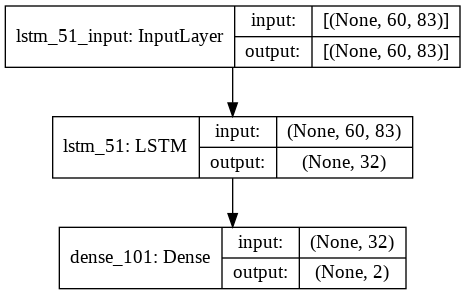

In [755]:
tf.keras.utils.plot_model(lstm_model, show_shapes=True)

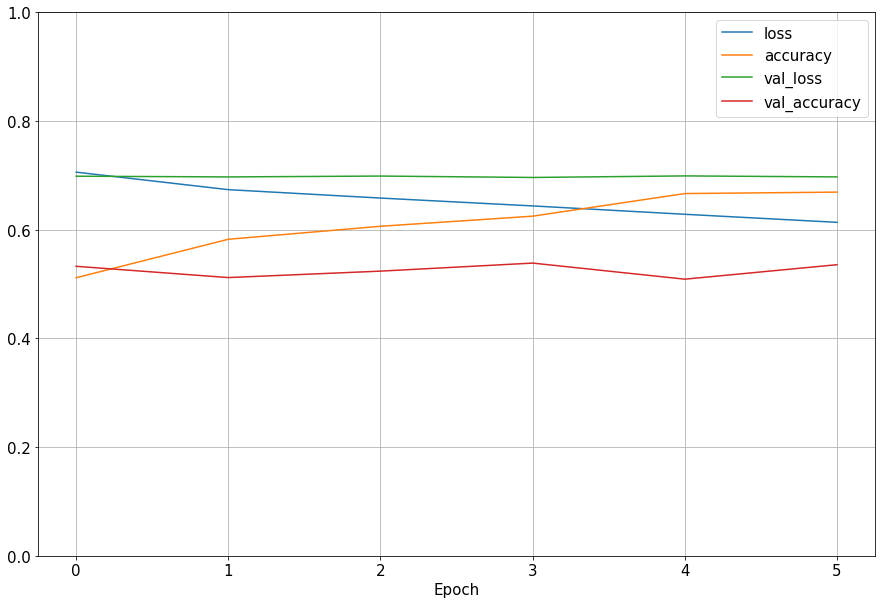

In [756]:
def plot_history(history):
    pd.DataFrame(history.history).plot()
    plt.grid(True)
    plt.gca().set_ylim(0, 1)
    plt.gca().set_xlabel("Epoch")
    plt.show()

plot_history(history)

## 2D-CNNPred

In [757]:
from functools import partial

cnn2d_pred_model = keras.models.Sequential([
    keras.layers.Conv2D(filters=8, kernel_size=(1,83), input_shape=[60, 83, 1], activation='relu'),
    keras.layers.Dropout(rate=0.1),
    keras.layers.Conv2D(filters=8, kernel_size=(3,1), activation='relu'),
    keras.layers.Dropout(rate=0.1),
    keras.layers.MaxPooling2D(pool_size=(2,1)),
    keras.layers.Dropout(rate=0.1),
    keras.layers.Conv2D(filters=8, kernel_size=(3,1), activation='relu'),
    keras.layers.Dropout(rate=0.1),
    keras.layers.MaxPooling2D(pool_size=(2,1)),
    keras.layers.Dropout(rate=0.1),
    keras.layers.Flatten(),
    keras.layers.Dropout(rate=0.1),
    keras.layers.Dense(units=1, activation='sigmoid')
])

In [758]:
history = compile_and_fit(cnn2d_pred_model, use_sparse=False, add_dim=True, batch_size=128)

Epoch 1/20
9/9 [==============================] - 1s 31ms/step - loss: 0.7289 - accuracy: 0.4715 - val_loss: 0.7023 - val_accuracy: 0.4615
Epoch 2/20
9/9 [==============================] - 0s 10ms/step - loss: 0.7060 - accuracy: 0.4961 - val_loss: 0.6967 - val_accuracy: 0.5207
Epoch 3/20
9/9 [==============================] - 0s 11ms/step - loss: 0.6908 - accuracy: 0.5371 - val_loss: 0.6989 - val_accuracy: 0.5237
Epoch 4/20
9/9 [==============================] - 0s 13ms/step - loss: 0.6890 - accuracy: 0.5558 - val_loss: 0.7000 - val_accuracy: 0.5207


In [759]:
score = cnn2d_pred_model.evaluate(nasdaq_val_X_3D[:,:,:,np.newaxis], nasdaq_val_y)
score

11/11 [==============================] - 0s 3ms/step - loss: 0.7000 - accuracy: 0.5207


[0.7000369429588318, 0.5207100510597229]

In [760]:
#pred_val = tf.argmax(cnn2d_pred_model.predict(nasdaq_val_X_3D[:,:,:,np.newaxis]), axis=1)
pred_val = np.where(cnn2d_pred_model.predict(nasdaq_val_X_3D[:,:,:,np.newaxis]) > 0.5, 1, 0)
print(classification_report(nasdaq_val_y, pred_val, digits=4))

              precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000       160
           1     0.5238    0.9888    0.6848       178

    accuracy                         0.5207       338
   macro avg     0.2619    0.4944    0.3424       338
weighted avg     0.2759    0.5207    0.3606       338



In [761]:
val_performance_acc['2D-CNNPred'] = accuracy_score(nasdaq_val_y, pred_val)
val_performance_f1_weighted['2D-CNNPred'] = f1_score(nasdaq_val_y, pred_val, average='weighted')

pred_test =  np.where(cnn2d_pred_model.predict(nasdaq_test_X_3D[:,:,:,np.newaxis]) > 0.5, 1, 0)

test_performance_acc['2D-CNNPred'] = accuracy_score(nasdaq_test_y, pred_test)
test_performance_f1_weighted['2D-CNNPred'] = f1_score(nasdaq_test_y, pred_test, average='weighted')

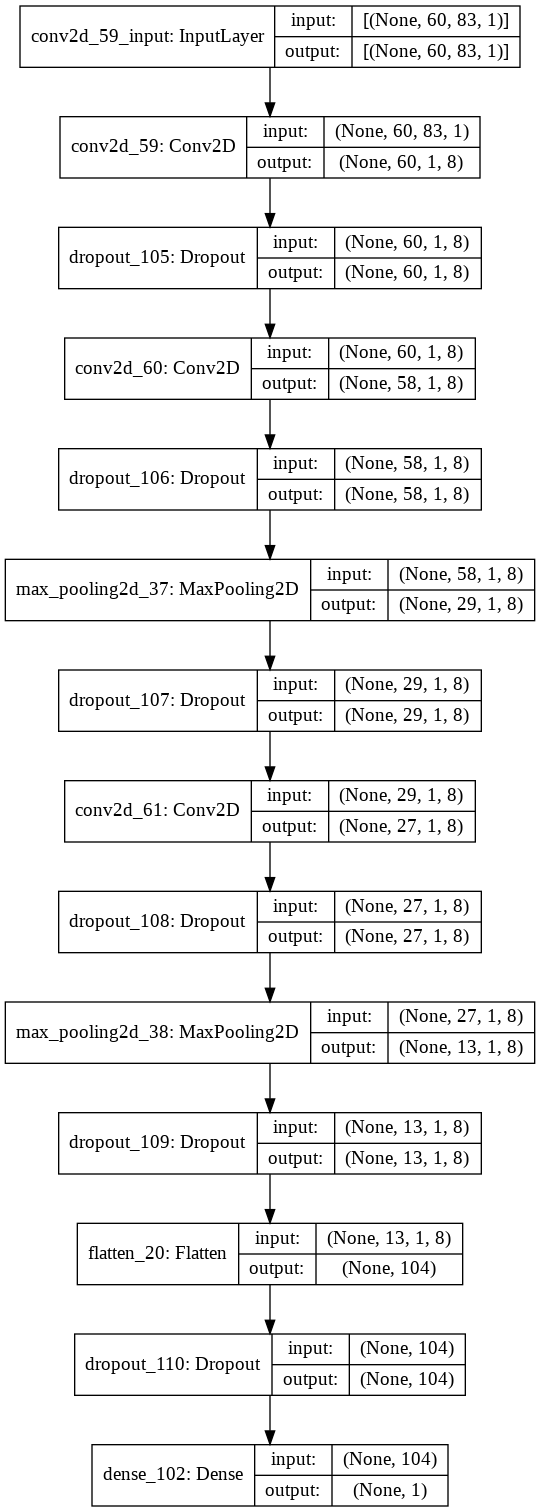

In [762]:
tf.keras.utils.plot_model(cnn2d_pred_model, show_shapes=True)

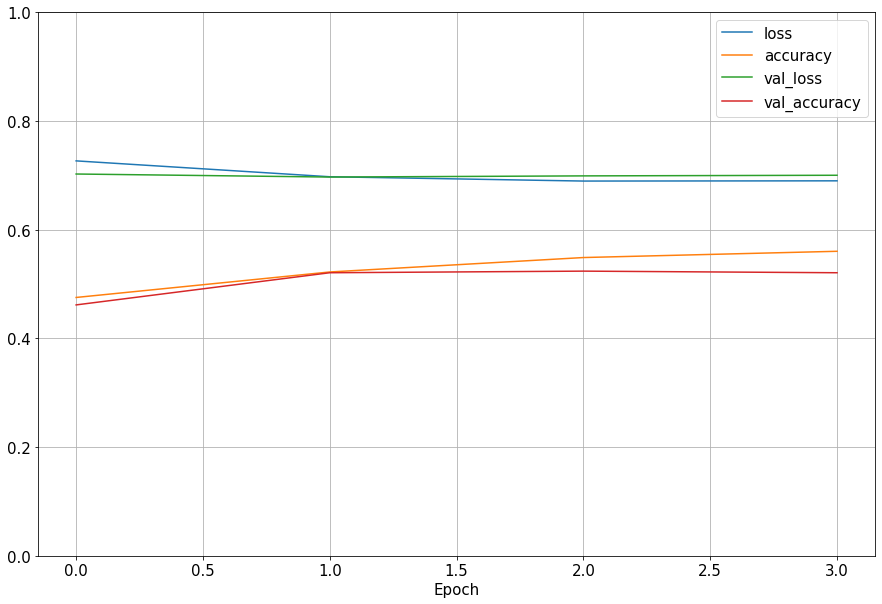

In [763]:
plot_history(history)

## CNN

## Logistic regression

First let's train a logistic regressor.

The selected starting learning rate and the learning rate schedule have been chosen after a process of tuning by looking at the results given by the metrics on the validation set.

The starting learning rate is **0.4**

The learning rate schedule is **adaptive** ([see](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html))




In [764]:
from sklearn.linear_model import SGDClassifier

log_reg = SGDClassifier(max_iter=400, tol=None, random_state=42,
                        loss="log", eta0=0.4, learning_rate="adaptive", penalty=None, n_jobs=-1)

log_reg.fit(nasdaq_train_X, nasdaq_train_y)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.4, fit_intercept=True,
              l1_ratio=0.15, learning_rate='adaptive', loss='log', max_iter=400,
              n_iter_no_change=5, n_jobs=-1, penalty=None, power_t=0.5,
              random_state=42, shuffle=True, tol=None, validation_fraction=0.1,
              verbose=0, warm_start=False)

Let's see what results it achieved on the training set.

In [765]:
pred_train = log_reg.predict(nasdaq_train_X)

confusion_matrix(nasdaq_train_y, pred_train)

array([[498,   0],
       [  0, 632]])

Cool! It was able to find a separation boundary that correctly classifies all the training instances.


<a name="cross_val"></a>

### Cross-validation

Now let's evaluate how well it generalises performing cross-validation.

Given the fact that our input is a time series, we cannot perform stratified K-fold or normal K-fold cross-validation, instead we can just split the time series incrementally (because test indieces must always be higher than training indices [see](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.TimeSeriesSplit.html)).

The default number of splits is 5 and we will keep that.

For cross-validation we use the set containing both trianing and validation samples ([see](#train_val))

In [766]:
from sklearn.model_selection import TimeSeriesSplit, cross_validate

tscv = TimeSeriesSplit()
ts_split = tscv.split(nasdaq_train_val_X, nasdaq_train_val_y)

for i, [train_index, test_index] in enumerate(ts_split):
    print(f"GROUP N°{i+1}: NUM OF SAMPLES IN THE SETS-> TRAIN: {len(train_index)}, TEST: {len(test_index)}")

GROUP N°1: NUM OF SAMPLES IN THE SETS-> TRAIN: 257, TEST: 254
GROUP N°2: NUM OF SAMPLES IN THE SETS-> TRAIN: 511, TEST: 254
GROUP N°3: NUM OF SAMPLES IN THE SETS-> TRAIN: 765, TEST: 254
GROUP N°4: NUM OF SAMPLES IN THE SETS-> TRAIN: 1019, TEST: 254
GROUP N°5: NUM OF SAMPLES IN THE SETS-> TRAIN: 1273, TEST: 254


Now we perform cross-validation and we tell sklearn what metrics we want to evaluate



In [767]:
metrics = ["accuracy","precision_weighted","recall_weighted","f1_weighted"]

In [768]:
cross_val_result = cross_validate(log_reg, nasdaq_train_val_X, nasdaq_train_val_y, cv=tscv.split(nasdaq_train_val_X, nasdaq_train_val_y), scoring=metrics, n_jobs=-1)

Now let's compute the avarege value for the metrics across the 5 groups:

In [769]:
for i in cross_val_result:
    cross_val_result[i] = cross_val_result[i].mean()
cross_val_result

{'fit_time': 5.157650423049927,
 'score_time': 0.005609464645385742,
 'test_accuracy': 0.49606299212598426,
 'test_f1_weighted': 0.49262109145107014,
 'test_precision_weighted': 0.5037011329728032,
 'test_recall_weighted': 0.49606299212598426}

We see that the result is not that good.

This is because this type of cross-validation is not as effective as stratified K-fold validation and because logistic regression may not be the best model for our task.

### Validation

Let's try evaluating the model on the validation set:

In [770]:
pred_val = log_reg.predict(nasdaq_val_X)

In [771]:
print(classification_report(nasdaq_val_y, pred_val, digits=4))

              precision    recall  f1-score   support

           0     0.5548    0.5062    0.5294       160
           1     0.5885    0.6348    0.6108       178

    accuracy                         0.5740       338
   macro avg     0.5717    0.5705    0.5701       338
weighted avg     0.5726    0.5740    0.5723       338



The lines of the ouput we are interested in are the one about accuracy and the last one containing the weighted metrics.

As we can see the result of this validation is better than the one we had for cross-validation. This is because cross-validation is not highly reliable for time series.

Let's also look at the confusion matrix:

In [772]:
confusion_matrix(nasdaq_val_y, pred_val)

array([[ 81,  79],
       [ 65, 113]])

And finally we plot also the ROC curve for our model.

To do this we calculate the classification scores for the instances of the validation set.

Note that we cannot use `cross_val_predict()` as it is not compatible with TimeSeries split for obvious reasons.

In [773]:
pred_val_scores = log_reg.decision_function(nasdaq_val_X)

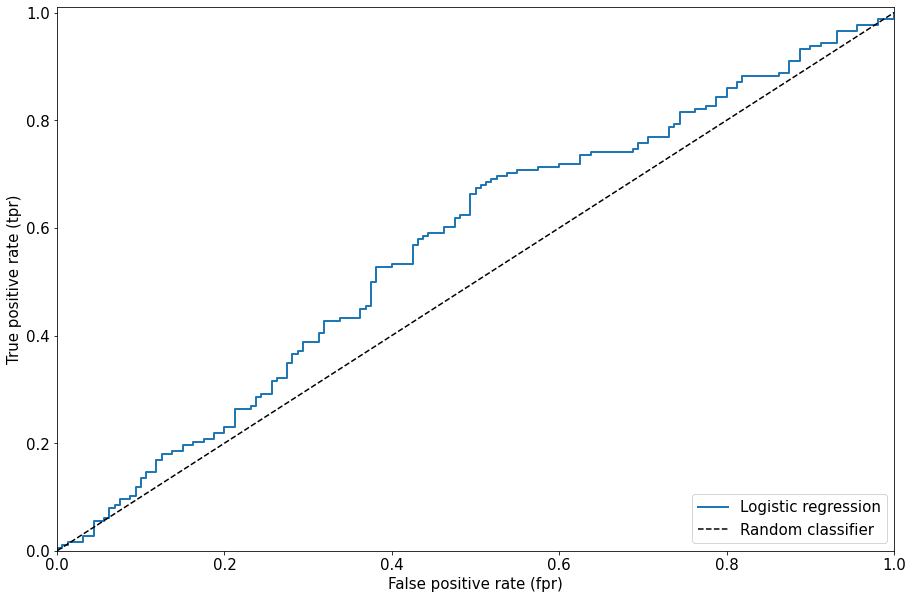

In [774]:
fpr_log_reg, tpr_log_reg, thresholds = roc_curve(nasdaq_val_y, pred_val_scores)

def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], "k--")
    plt.axis([0, 1, 0, 1.01])
    plt.xlabel("False positive rate (fpr)")
    plt.ylabel("True positive rate (tpr)")
    plt.legend([label, "Random classifier"], loc="lower right")
    
plot_roc_curve(fpr_log_reg, tpr_log_reg, label="Logistic regression")

Looking at the area underneath the curve we can see how well our model performs compared to the random classifier:

In [775]:
roc_auc_score(nasdaq_val_y, pred_val_scores)

0.5670294943820224

The more the area is grater than 0.5, the more our model performs better than random.

### Considerations

This model achieves a Weighted-$F_1$-Score of 0.5723 on the validation set.

The authors of the paper run their algorithm multiple times for comparison porpuses and obtain, for 2D-CNNPred, a Macro-Averaged-$F_{1}$-Measure mean of 0.4779, with a maximum value of 0.5219 on the NASDAQ dataset.

However their runs refer to the test set, for which we still don't know how this model will preform.

It is also to be kept in mind that 2D-CNNPred is trained using all the datasets, while our model considers only NASDAQ Composite.

We will not yet look at the performance of our models on the test set.
This wil be done only at the very end of the project after we select the best performing model based on the validation performances.

In [776]:
val_performance_acc['Log Reg'] = accuracy_score(nasdaq_val_y, pred_val)
val_performance_f1_weighted['Log Reg'] = f1_score(nasdaq_val_y, pred_val, average='weighted')

pred_test =  log_reg.predict(nasdaq_test_X)

test_performance_acc['Log Reg'] = accuracy_score(nasdaq_test_y, pred_test)
test_performance_f1_weighted['Log Reg'] = f1_score(nasdaq_test_y, pred_test, average='weighted')

## Ensemble hard voting

Now we try to use an ensemble of 4 classifiers, the used classifiers are:

*   Gaussian Naive Bayes (we infer the prior of the classes directly from the data)
*   Logistic Regression (the one that we just used)
*   Perceptron
*   Support Vector Machine

We use hard voting as the SGD classifier used to model the perceptron does not provide probability estimates.

In [777]:
from sklearn.ensemble import VotingClassifier

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import GaussianNB


gnb_clf = GaussianNB()
log_clf = SGDClassifier(max_iter=400, tol=None, random_state=42,
                        loss="log", eta0=0.4, learning_rate="adaptive", penalty=None, n_jobs=-1)
perc_clf = SGDClassifier(max_iter=400, tol=None, random_state=42,
                   loss="perceptron", eta0=1, learning_rate="constant", penalty=None, n_jobs=-1)
svm_clf = SVC(random_state=42, probability=True)

voting_clf = VotingClassifier(
    estimators=[('gnb', gnb_clf), ('log', log_clf), ('perc', perc_clf), ('svm',svm_clf)],
    voting='hard')

Let's now see the evaluation metrics on each single classifier and on the voting classifier.

In [778]:
for clf in (gnb_clf, log_clf, perc_clf, svm_clf, voting_clf):
    clf.fit(nasdaq_train_X, nasdaq_train_y)
    pred_val = clf.predict(nasdaq_val_X)
    print(clf.__class__.__name__, '\n', classification_report(nasdaq_val_y, pred_val, digits=3))

/usr/local/lib/python3.6/dist-packages/sklearn/naive_bayes.py:206: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


GaussianNB 
               precision    recall  f1-score   support

           0      0.469     0.431     0.450       160
           1      0.524     0.562     0.542       178

    accuracy                          0.500       338
   macro avg      0.496     0.497     0.496       338
weighted avg      0.498     0.500     0.498       338

SGDClassifier 
               precision    recall  f1-score   support

           0      0.555     0.506     0.529       160
           1      0.589     0.635     0.611       178

    accuracy                          0.574       338
   macro avg      0.572     0.571     0.570       338
weighted avg      0.573     0.574     0.572       338



/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SGDClassifier 
               precision    recall  f1-score   support

           0      0.542     0.487     0.513       160
           1      0.577     0.629     0.602       178

    accuracy                          0.562       338
   macro avg      0.559     0.558     0.558       338
weighted avg      0.560     0.562     0.560       338



/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SVC 
               precision    recall  f1-score   support

           0      0.714     0.031     0.060       160
           1      0.532     0.989     0.692       178

    accuracy                          0.536       338
   macro avg      0.623     0.510     0.376       338
weighted avg      0.618     0.536     0.393       338



/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


VotingClassifier 
               precision    recall  f1-score   support

           0      0.582     0.512     0.545       160
           1      0.604     0.669     0.635       178

    accuracy                          0.595       338
   macro avg      0.593     0.591     0.590       338
weighted avg      0.593     0.595     0.592       338



We can see that singularly SVM and Naive Bayes do nat perform very good, but in the ensemble with the Logistic Regresssion and the Perceptron (which we see performing slightly better) they provide surprising results.

Although it is hard to train the models in a way that they provide uncorrelated errors, the result we obtain with this method is an improvement with respect to the Logistic Regression classifier (treated in the previous section) alone.

The voting classifier achieves perfect results on the training set.

In [779]:
pred_train = voting_clf.predict(nasdaq_train_X)

confusion_matrix(nasdaq_train_y, pred_train)

KeyboardInterrupt: ignored

### Cross-validation

Now let's evaluate how well it generalises performing cross-validation (details on this have been given in [this section](#cross_val)).

In [ ]:
cross_val_result = cross_validate(voting_clf, nasdaq_train_val_X, nasdaq_train_val_y, cv=tscv.split(nasdaq_train_val_X, nasdaq_train_val_y), scoring=metrics, n_jobs=-1)

Now let's compute the avarege value for the metrics across the 5 groups:

In [ ]:
for i in cross_val_result:
    cross_val_result[i] = cross_val_result[i].mean()
cross_val_result

We see that the result is not that good.

This is because this type of cross-validation is not as effective as stratified K-fold validation.

### Validation

Let's try evaluating the model on the validation set:

In [780]:
pred_val = voting_clf.predict(nasdaq_val_X)

In [781]:
print(classification_report(nasdaq_val_y, pred_val, digits=4))

              precision    recall  f1-score   support

           0     0.5816    0.5125    0.5449       160
           1     0.6041    0.6685    0.6347       178

    accuracy                         0.5947       338
   macro avg     0.5928    0.5905    0.5898       338
weighted avg     0.5934    0.5947    0.5922       338



The lines of the ouput we are interested in are the one about accuracy and the last one containing the weighted metrics.

As we can see the result of this validation is better than the one we had for cross-validation. This is because cross-validation is not highly reliable for time series.

Let's also look at the confusion matrix:

In [782]:
confusion_matrix(nasdaq_val_y, pred_val)

array([[ 82,  78],
       [ 59, 119]])

We cannot loo at the ROC Curve as the classifier uses hard voting and therefore doesn't output the probability of the predictions.

### Considerations

This model achieves a Weighted-$F_1$-Score of 0.592 on the validation set, which is better than the result achieved by Logistic Regression alone.

We will not yet look at the performance of our models on the test set.
This wil be done only at the very end of the project after we select the best performing model based on the validation performances.

In [783]:
val_performance_acc['Voting Clf'] = accuracy_score(nasdaq_val_y, pred_val)
val_performance_f1_weighted['Voting Clf'] = f1_score(nasdaq_val_y, pred_val, average='weighted')

pred_test =  voting_clf.predict(nasdaq_test_X)

test_performance_acc['Voting Clf'] = accuracy_score(nasdaq_test_y, pred_test)
test_performance_f1_weighted['Voting Clf'] = f1_score(nasdaq_test_y, pred_test, average='weighted')

## Other classifiers

We have also tried a selection of various classifiers which have been less succesfull.

Here we briefly report them:

### Bagging classifier

In [784]:
from sklearn.ensemble import BaggingClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier

#use bootstrap=False for pasting
bag_clf = BaggingClassifier(
    SGDClassifier(max_iter=300, tol=None, random_state=42,
                        loss="log", eta0=0.4, learning_rate="adaptive", penalty=None, n_jobs=-1),
    n_estimators=200,
    max_samples=nasdaq_train_X.shape[0], max_features=0.8, 
    bootstrap=True, bootstrap_features=False,
    n_jobs=-1, random_state=42)

bag_clf.fit(nasdaq_train_X, nasdaq_train_y)

/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


KeyboardInterrupt: ignored

In [ ]:
pred_val = bag_clf.predict(nasdaq_val_X)
print(classification_report(nasdaq_val_y, pred_val, digits=3))

### Random forrest

In [ ]:
from sklearn.ensemble import RandomForestClassifier

rnd_clf = RandomForestClassifier(n_estimators=300, max_leaf_nodes=40, 
                                 n_jobs=-1, random_state=42)

rnd_clf.fit(nasdaq_train_X, nasdaq_train_y)

In [ ]:
pred_val = rnd_clf.predict(nasdaq_val_X)
print(classification_report(nasdaq_val_y, pred_val, digits=3))

## Comparison

### Validation

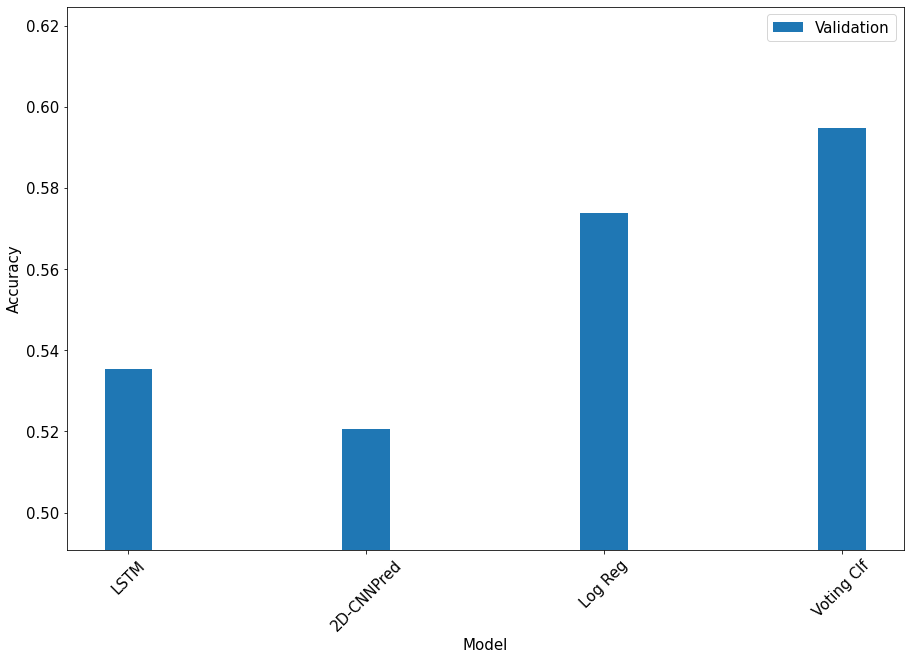

In [785]:
x = np.arange(len(val_performance_acc))
width = 0.2
vals = list(val_performance_acc.values())


plt.ylabel('Accuracy')
plt.xlabel('Model')
plt.bar(x, vals, width, label='Validation')

plt.xticks(ticks=x, labels=val_performance_acc.keys(),
           rotation=45)
plt.ylim(np.min(vals) - 0.03, np.max(vals) + 0.03)

plt.legend()

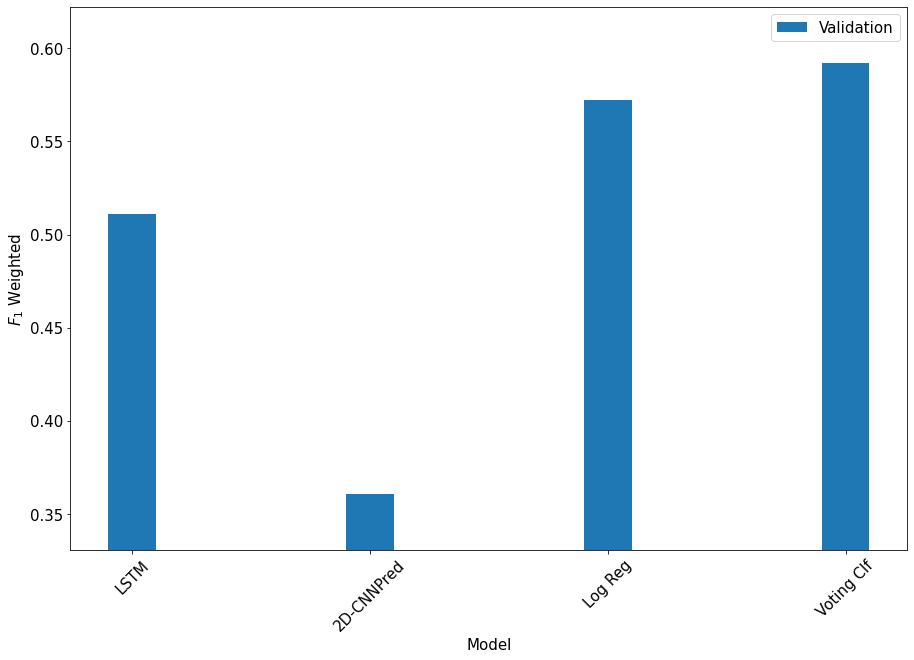

In [786]:
x = np.arange(len(val_performance_f1_weighted))
width = 0.2
vals = list(val_performance_f1_weighted.values())


plt.ylabel('$F_1$ Weighted')
plt.xlabel('Model')
plt.bar(x, val_mae, width, label='Validation')

plt.xticks(ticks=x, labels=val_performance_acc.keys(),
           rotation=45)
plt.ylim(np.min(vals) - 0.03, np.max(vals) + 0.03)
plt.legend()

### Test

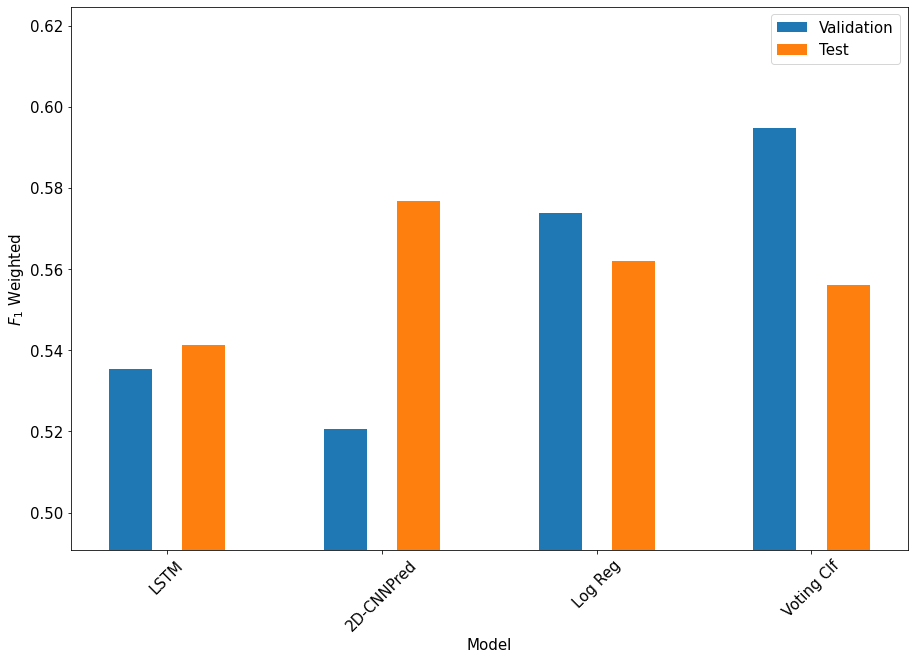

In [789]:
x = np.arange(len(test_performance_acc))
width = 0.2

val_acc = list(val_performance_acc.values())
test_acc = list(test_performance_acc.values())

plt.bar(x - 0.17, val_acc, width, label='Validation')
plt.bar(x + 0.17, test_acc, width, label='Test')

plt.ylabel('Accuracy')
plt.xlabel('Model')

plt.xticks(ticks=x, labels=test_performance_acc.keys(),
           rotation=45)
plt.ylim(np.min([val_acc, test_acc]) - 0.03, np.max([val_acc, test_acc]) + 0.03)

plt.legend()

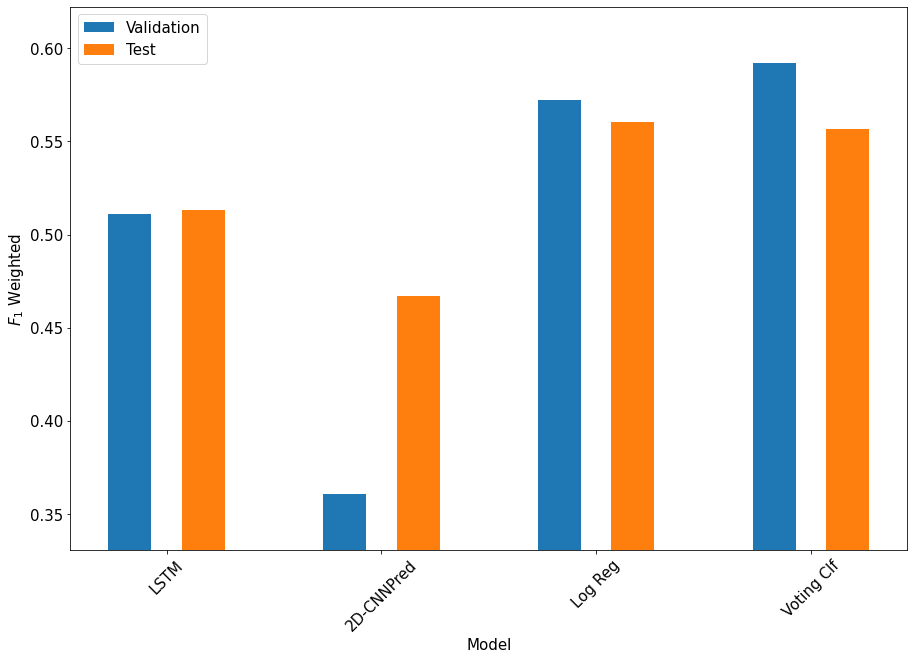

In [790]:
x = np.arange(len(test_performance_f1_weighted))
width = 0.2

val_acc = list(val_performance_f1_weighted.values())
test_acc = list(test_performance_f1_weighted.values())

plt.bar(x - 0.17, val_acc, width, label='Validation')
plt.bar(x + 0.17, test_acc, width, label='Test')

plt.ylabel('$F_1$ Weighted')
plt.xlabel('Model')

plt.xticks(ticks=x, labels=test_performance_f1_weighted.keys(),
           rotation=45)
plt.ylim(np.min([val_acc, test_acc]) - 0.03, np.max([val_acc, test_acc]) + 0.03)

plt.legend()